# **UTILIZZO DI MODELLI DI COMPUTER VISION PER LA CLASSIFICAZIONE DELLE MALATTIE POLMONARI**

## **INTRODUZIONE**

Una delle frontiere più interessanti e più socialmente rilevanti dell'utilizzo dell'apprendimento automatico è l'applicazione delle sue tecniche in campo medico. Queste sono infatti utili per supportare e potenziare le capacità di rilevazione di patologie specifiche, garantendo importanti benefici per quanto riguarda sia la prevenzione che la cura di diverse patologie.

Tale utilità è emersa anche durante la pandemia recentemente trascorsa dovuta alla diffusione del coronavirus SarsCov2. Ai fini del supporto alla diagnostica della positività al virus si è infatti dimostrato utile, specialmente nelle prime fasi, il ricorso all'intelligenza artificiale a supporto delle decisioni degli specialisti.

Nel mio progetto viene proposto un caso pratico di detection di patologie che affliggono il tratto respiratorio degli individui, in particolare il tessuto polmonare, partendo da un dataset di radiografie al petto.

### OBIETTIVI DELLA RICERCA

 L'obiettivo è quello di classificare una serie di radiografie al torace suddivise tra individui sani, affetti da covid, affetti da opacità polmonare e da polmonite virale.

 Per effettuare la classificazione sono proposti tre modelli di reti neurali:
*   Model1: architettura convoluzionale che presenta 4 strati convoluzionali, ciascuno composto da un livello Conv2D, un livello di Maxpooling e uno di Dropout;
*   Model2: estensione del model1, che presenta come variante due livelli Conv2D impilati per ogni strato convoluzionale, mantenendo gli altri principi architetturali e valutando il comportamento di una rete con maggiore complessità rispetto al modello precedente;
*   Model3: architettura preaddestrata Vgg16, per un confronto sia in transfer learning che in fine tuning tra i precedenti modelli creati da zero e una rete già addestrata su set di dati più eterogenei e più grandi.

Ciascuna architettura verrà valutata sulla base delle sue performance in classificazione, utilizzando la metrica dell'accuracy affiancata da precision e recall.

Per valutare la possibilità di ampliare le capacità di generalizzazione, verrà disposta una data augmentation, utile per aumentare le dimensioni del dataset di partenza, potenziare le prestazioni e combattere l'overfitting, migliorando potenzialmente la rispota dei modelli in un contesto applicativo più verosimile.

L'ultima parte dell'elaborato tratta la spiegabilità algoritmica. La difficoltà nello spiegare i perché delle decisioni prese dal modello rappresenta uno dei problemi più importanti da affrontare per modelli di una certa complessità, come quelli trattati nel corso. Si propone dunque l'utilizzo della tecnica GradCAM per verificare le aree dell'immagine che hanno determinato una maggiore attivazione nel modello, analizzando le eventuali differenze che possono intercorrere tra una classe e l'altra.

## **IMPORT E ANALISI PRELIMINARI**

## INSTALLAZIONE E IMPORT DELLE LIBRERIE NECESSARIE PER L'ANALISI

Per l'elaborazione del progetto, non c'è stata la necessità di installare librerie specifiche su Colab. Si procede dunque all'import di quelle preinstallate necessarie al funzionamento del codice:

In [ ]:
import tensorflow as tf # Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Preprocessing
from PIL import Image # Manipolazione immagini
import numpy as np # Manipolazione array e operazioni matematiche
from tensorflow.keras.preprocessing import image # Manipolazione immagini
from tensorflow.keras.metrics import Precision, Recall # Metriche aggiuntive
import matplotlib.pyplot as plt # Pyplot
import matplotlib # Operazioni particolari per i plot
from matplotlib import cm # Color map
from sklearn import metrics # Confusion matrix
from collections import Counter # Processing di oggetti
import shutil # Manipolazione dataset
import random # Random seed
import math # Calcoli matematici
import os # Interazioni con il sistema

from google.colab import drive # Collegamento a Google Drive
import zipfile # Spacchettamento archivio compresso

Il presente notebook è stato predisposto per funzionare su Google Colab, al fine di poter sviluppare modelli più complessi rispetto a quelli sostenibili dalle mie risorse hardware personali.

In particolare, è stato utilizzato il runtime "GPU T4".
Non è stato necessario installare particolari versioni di Tensorflow o predisporre specifiche impostazioni per poter eseguire i processi sul server.

La seguente stringa di codice verifica, una volta connesso adeguatamente il runtime sopra indicato, il nome del dispositivo GPU al quale il runtime medesimo si è connesso.

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

## IMPORT DEI FILE

Il dataset scelto è stato reperito su Kaggle al seguente indirizzo web:

https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

È stato pubblicato da un team di ricercatori provenienti dalle università di Doha (Qatar) e Dhaka (Bangladesh), con la collaborazione di alcuni colleghi di istituti accademici del Pakistan e della Malesia e di alcuni medici e specialisti radiologi.

Si tratta di un dataset contenente immagini di radiografie al petto suddivise in sottocartelle, ciascuna delle quali rappresenta una specifica classe. Sono contenuti anche file che non saranno utilizzati per l'analisi.

Pur essendo presenti anche altre versioni del medesimo dataset reperibii nel web, si è deciso di usare quello indicato per la sua completezza, sia dal punto di vista quantitativo (più dati rispetto ad altri) che per il numero di classi (4 anziché 2).

Si importano i file da Google Drive. In precedenza, è stato caricato direttamente il file zip del dataset nella root del drive.
Questo è utile per mantenere in cloud i file e caricarli facilmente in colab. La cartella dalla quale si carica il file zip è: "/content/drive/MyDrive/COVID-19_Radiography_Dataset.zip".

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Successivamente, si estrae il zip nella cartella '/content' di Colab al fine di velocizzare le successive elaborazioni, le quali sarebbero troppo lente in caso di lettura da Drive.

In [ ]:
zip_file_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset.zip' # path del file zip
destination_path = '/content' # path di destinazione

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_path)

## ANALISI ESPLORATIVA

Si esegue una piccola analisi esplorativa, al fine di identificare il corretto caricamento del dataset di partenza e la sua consistenza in termini di suddivisione delle classi.

Ai fini esemplificativi, si esegue un plot di un'immagine per ogni sottocartella, ciascuna delle quali rappresenta una singola classe:

In [ ]:
def plot_image(path): # Questa funzione prende in ingresso una lista di 4 percorsi predeterminati e ne esegue il plot
    image1 = image.load_img(path[0])
    image2 = image.load_img(path[1])
    image3 = image.load_img(path[2])
    image4 = image.load_img(path[3])
    fig, axs = plt.subplots(1, 4, figsize = (10,10)) # Vengono disposti dei subplot, 4 colonne distribuite in una riga

    # Ad ogni asse vengono assegnati un'immagine, il titolo e viene disattivata la rappresentazione degli assi
    axs[0].imshow(image1)
    axs[0].set_title('Covid', color='black')
    axs[0].axis('off')

    axs[1].imshow(image3)
    axs[1].set_title('Normal', color='black')
    axs[1].axis('off')

    axs[2].imshow(image2)
    axs[2].set_title('Lung Opacity', color='black')
    axs[2].axis('off')

    axs[3].imshow(image4)
    axs[3].set_title('Viral Pneumonia', color='black')
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()

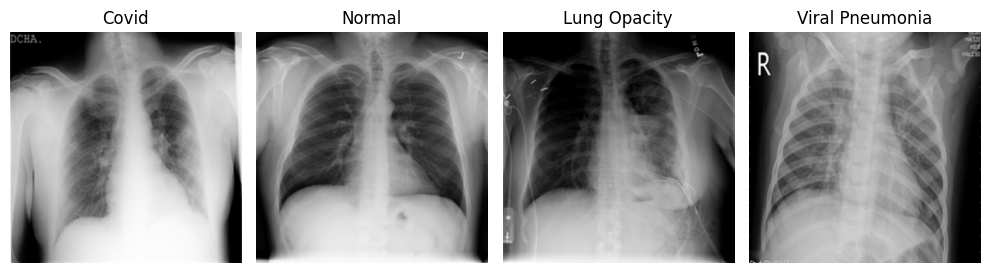

In [ ]:
# Lista delle immagini che si vogliono visualizzare
img_list = [r"/content/COVID-19_Radiography_Dataset/COVID/images/COVID-100.png", r"/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1.png",
			r"/content/COVID-19_Radiography_Dataset/Normal/images/Normal-10.png", r"/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1.png"]
plot_image(img_list) # Plot delle immagini nella lista

Le classi sono 4:


*   Covid: individui che hanno contratto la malattia SARS-CoV-2
*   Normal: individui sani
*   Lung Opacity: opacità polmonari, spesso riscontrate a causa della presenza di noduli polmonari
*   Viral Pneumonia: individui affetti da polmonite virale per patogeni diversi dal SARS-CoV-2








Si eseguono il conteggio e il plot di un istogramma per verificare il numero delle occorrenze a disposizione per ogni classe:

In [ ]:
def count_occurrences(): # Conta il numero di file in ogni sottocartella
	covid_occ = len(os.listdir(r"/content/COVID-19_Radiography_Dataset/COVID/images"))
	normal_occ = len(os.listdir(r"/content/COVID-19_Radiography_Dataset/Normal/images"))
	lung_occ = len(os.listdir(r"/content/COVID-19_Radiography_Dataset/Lung_Opacity/images"))
	penumonia_occ = len(os.listdir(r"/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images"))

	print("Normal:", normal_occ,"\nCovid:", covid_occ, "\nLung Opacity:", lung_occ, "\nViral Pneumonia:", penumonia_occ)
	return [normal_occ, covid_occ, lung_occ, penumonia_occ]

def plot_n_occurrences(n_occ): # Si esegue il plot di un istogramma con X = classi e Y = numero di occorrenze per classe
	labels = ["Normal", "Covid", "Lung Opacity", "Viral Pneumonia"]
	values = n_occ
	plt.bar(labels, values)
	plt.title("Occurrences in dataset")
	plt.show()

Normal: 10192 
Covid: 3616 
Lung Opacity: 6012 
Viral Pneumonia: 1345


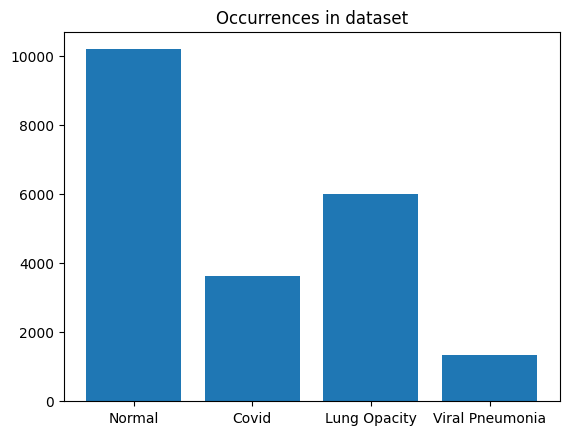

In [ ]:
n_occ = count_occurrences()
plot_n_occurrences(n_occ)

Si osserva un leggero squilibrio a favore della classe "Normal", mentre la classe "Viral Pneumonia" risulta la meno rappresentata. Questo potrebbe portare ad una leggera predisposizione da parte dei modelli a classificare verso la classe più frequente. L'influenza di questo fenomeno potrebbe essere ridotta ricorrendo a tecniche di data augmentation, le quali permettono di ampliare le dimensioni del dataset di partenza.

## DATA PREPROCESSING

Nel dataset sono presenti alcune cartelle di scarso interesse, in quanto contengono dei file "mask" che non verranno utilizzati per l'analisi proposta.
Dunque, si procede all'eliminazione di queste sottocartelle:.

In [ ]:
def delete_masks_folders(): # Elimina le directory indicate nella lista e i file in esse contenuti
	to_delete = [r"/content/COVID-19_Radiography_Dataset/COVID/masks", r"/content/COVID-19_Radiography_Dataset/Normal/masks",
			   r"/content/COVID-19_Radiography_Dataset/Lung_Opacity/masks", r"/content/COVID-19_Radiography_Dataset/Viral Pneumonia/masks"]
	for folder in to_delete:
		shutil.rmtree(folder)

delete_masks_folders()

Si esegue una divisione tra training set e test set, al fine di poter valutare meglio le performance del modello.
Si sposta dunque il 15% delle immagini in una cartella dedicata.

In [ ]:
def divide_train_test():
	sources = [r"/content/COVID-19_Radiography_Dataset/COVID/images", r"/content/COVID-19_Radiography_Dataset/Normal/images",
			   r"/content/COVID-19_Radiography_Dataset/Lung_Opacity/images", r"/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images"]
	destinations = [r"/content/COVID-19_Radiography_Testset/COVID", r"/content/COVID-19_Radiography_Testset/Normal",
					r"/content/COVID-19_Radiography_Testset/Lung_Opacity", r"/content/COVID-19_Radiography_Testset/Viral Pneumonia"]

	current = 0 # Indice per la selezione della destinazione
	for source in sources:
		file_list = os.listdir(source) # Restituisce la lista di file nella directory
		random.seed(55) # Il seed viene impostato per garantire la replicabilità della suddivisione
		random.shuffle(file_list) # Garantisce che le immagini nella lista siano mescolate casualmente. Si segue il seed impostato in precedenza (55) per la replicabilità dei risultati
		destination = destinations[current] # Associa la destinazione alla fonte attualmente selezionata
		os.makedirs(destination, exist_ok=True) # Crea le cartelle. Se esiste già, non viene ricreata
		target_selection = 0.15 # Dimensione del subset da spostare (relativa)
		files_to_testset = math.ceil(len(file_list)*target_selection) # Dimensione del subset da spostare (assoluta)
		for filename in file_list[-files_to_testset:]: # Spostamento dei file da fonte a destinazione
			source_file_path = os.path.join(source, filename)
			destination_file_path = os.path.join(destination, filename)
			shutil.move(source_file_path, destination_file_path)
		current += 1 # Modifica dell'indice per la selezione della destinazione

divide_train_test()

Si generano i test di addestramento utilizzando il preprocessing di Keras, specificando nel caso del training set un validation split per la valutazione durante l'allenamento pari al 20% del training set:

In [ ]:
train_data_dir = r"/content/COVID-19_Radiography_Dataset" # Path del training set
test_data_dir = r"/content/COVID-19_Radiography_Testset" # Path del test set

def generate_train_data(path): # Genera i dati di training
	np.random.seed(10) # Garantisce la replicabilità dei risultati per la selezione del validation split
	datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, validation_split = 0.2) # Preprocessing normalizzando i valori dei pixel e determinazione della grandezza del validations set

	train_generator = datagen.flow_from_directory( # Flow from directory permette di caricare le immagini usando i nomi delle sottocartelle come nomi delle classi
		path,
		batch_size=batch_size,
 		class_mode='categorical', # Per classificazione multiclasse, codifica one-hot
		target_size=(height, width), # Dimensioni delle immagini
		subset='training', # Subset desiderato per train generator
		color_mode="grayscale" # Si decide di caricare le immagini ad 1 canale, mantenendo la codifica originale delle stesse (scala di grigi)
    )

	validation_generator = datagen.flow_from_directory( # Stesso discorso che per il train_generator, ma cambiando il subset
		path,
		batch_size=batch_size,
		class_mode='categorical',
		target_size=(height, width),
		subset='validation',
		color_mode="grayscale"
	)
	return train_generator, validation_generator

def generate_test_data(path): # Genera i dati di test
	datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255) # Stessa normalizzazione vista in precedenza
	test_generator = datagen.flow_from_directory(
		path,
		batch_size=batch_size,
 		class_mode='categorical',
		target_size=(height, width),
		color_mode="grayscale",
		shuffle=False
    )
	return test_generator

def img_info(train_generator): # Estrare e restituisce le informazioni sull'immagine, eseguendone successivamente il plot
	sample_image, _ = train_generator.next() # Estrae un'immagine casuale dal train generator
	image_shape = sample_image.shape[1:]
	num_channels = image_shape[-1]

	print("\nDimensione dell'immagine:", image_shape)
	print()
	plt.imshow(sample_image[0, ..., 0], cmap='gray')
	plt.title(f"Dimensione: {image_shape}, Canali: {num_channels}")
	plt.axis('off')
	plt.show()

Si eseguono le funzioni definite in precedenza e si plotta un'immagine casuale estratta dal trainingset, verificando la correttezza dei parametri (290 x 290, 1 canale)

Found 14393 images belonging to 4 classes.
Found 3596 images belonging to 4 classes.
Found 3176 images belonging to 4 classes.
Etichette: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

Dimensione dell'immagine: (290, 290, 1)



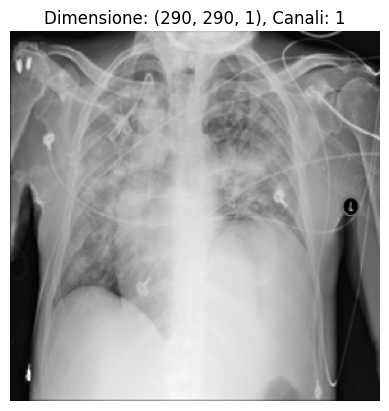

In [ ]:
# Si impostano i parametri target
height, width = 290, 290 # Dimensioni immagine
batch_size = 32 # Dimensione del batch

# Generazione
train_generator, validation_generator = generate_train_data(train_data_dir)
test_generator = generate_test_data(test_data_dir)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())
print("Etichette:", class_labels)

img_info(train_generator)

## **DEFINIZIONE DEI MODELLI E ANALISI**

##MODELLO 1

L'architettura proposta è composta da una serie di strati convoluzionali ottenuti combinando un livello Conv2D e un livello di pooling.

Si definisce la rete neurale convoluzionale "model1" senza eseguire, per il momento, nessun dropout.

Il numero dei filtri è scelto a scalare. L'idea è quella di potenziare l'estrazione dei dettagli aumentando il numero di filtri quando la dimensionalità è stata ridotta e le caratteristiche generali sono già state estratte dai livelli precedenti.

La dimensione del kernel è fissata a 3x3, la funzione di attivazione relu garantisce l'inserimento di non linearità senza soffrire del problema dei gradienti evanescenti.

I livelli di maxpooling permettono di ridurre la dimensione della feature map, permettendo al modello di concentrarsi su caratteristiche più dettagliate e riducendo il numero di parametri che arriveranno ai livelli densamente connessi.

Il livello flatten vettorizza l'immagine per renderla processabile dai livelli dense, i quali elaborano le informazioni estratte dai livelli convoluzionali combinando le feature map. Il secondo livello dense in particolare restituisce in output le probabilità per ogni classe associate alle immagini in ingresso (funzione softmax).

Per la compilazione si usa come funzione di perdita la categorical crossentropy, adatta alla classificazione multiclasse. L'ottimizzatore Adam ricalca una scelta popolare per questo tipo di modelli, in quanto si tratta di un algoritmo di ottimizzazione con learning rate adattivo che combina i benefici di SGD e RMSProp.

In [ ]:
model1 = tf.keras.models.Sequential([
			tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape=(width, height, 1)),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(256, activation='relu'),
			tf.keras.layers.Dense(num_classes, activation='softmax')
		])
print("\n",model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 288, 288, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 144, 144, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 142, 142, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 71, 71, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 69, 69, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 34, 34, 128)     

Si esegue il fit del modello:

In [ ]:
# Compilazione seguento l'ottimizzatore adam, scelta molto popolare, categorical crossentropy come funzione di perdita e accuracy, precision e recall come metriche di valutazione
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
history_model1 = model1.fit(train_generator, epochs = 20, validation_data = validation_generator)

Epoch 1/20
450/450 [==============================] - 58s 124ms/step - loss: 0.6826 - accuracy: 0.7214 - precision_4: 0.7806 - recall_4: 0.6401 - val_loss: 0.5378 - val_accuracy: 0.7839 - val_precision_4: 0.8143 - val_recall_4: 0.7389
Epoch 2/20
450/450 [==============================] - 54s 120ms/step - loss: 0.4278 - accuracy: 0.8353 - precision_4: 0.8497 - recall_4: 0.8176 - val_loss: 0.3977 - val_accuracy: 0.8484 - val_precision_4: 0.8664 - val_recall_4: 0.8262
Epoch 3/20
450/450 [==============================] - 54s 121ms/step - loss: 0.3311 - accuracy: 0.8761 - precision_4: 0.8849 - recall_4: 0.8663 - val_loss: 0.3710 - val_accuracy: 0.8601 - val_precision_4: 0.8693 - val_recall_4: 0.8543
Epoch 4/20
450/450 [==============================] - 54s 120ms/step - loss: 0.2705 - accuracy: 0.8979 - precision_4: 0.9035 - recall_4: 0.8904 - val_loss: 0.3947 - val_accuracy: 0.8579 - val_precision_4: 0.8631 - val_recall_4: 0.8518
Epoch 5/20
450/450 [==============================] - 56s 12

Per poter ricaricare il modello addestrato in futuro, si può salvare il checkpoint su Google Drive:

In [ ]:
def save_checkpoint(model, path):
  checkpoint_path = path
  model.save_weights(checkpoint_path)

In [ ]:
save_checkpoint(model1, "/content/drive/MyDrive/Colab/checkpoints/model1_checkpoint.ckpt")

Si effettua il plot dei risultati dell'addestramento su training e validation set:

In [ ]:
def plot_results(history): # Codice estratto dai notebook proposti nelle fasi di laboratorio
	accuracy = history.history["accuracy"] # Valori dell'accuracy su training set registrati durante il fit per ogni epoca
	val_accuracy = history.history["val_accuracy"] # Valori dell'accuracy su validation set registrati durante il fit per ogni epoca

	loss = history.history["loss"] # Valori della loss function su training set registrati durante il fit per ogni epoca
	val_loss = history.history["val_loss"] # Valori della loss function su validation set registrati durante il fit per ogni epoca

	epochs = range(1, len(accuracy) + 1) # Numero di epoche (asse x)

	# Plot delle curve
	plt.plot(epochs, accuracy, "bo", label="Accuratezza in addestramento")
	plt.plot(epochs, val_accuracy, "b", label="Accuratezza in validazione")
	plt.title("Accuratezza in addestramento e validazione")
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, "bo", label="Loss in addestramento")
	plt.plot(epochs, val_loss, "b", label="Loss in validazione")
	plt.title("Loss in addestramento e validazione")
	plt.legend()

	plt.show()

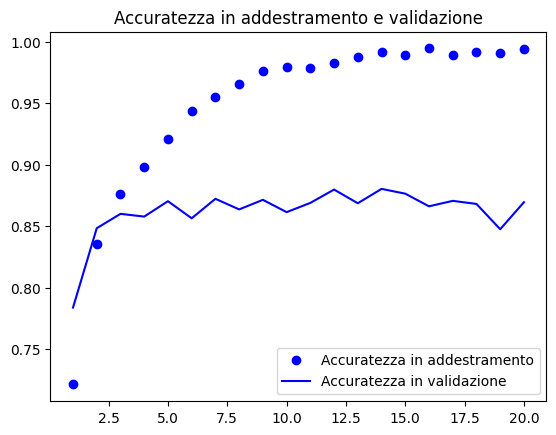

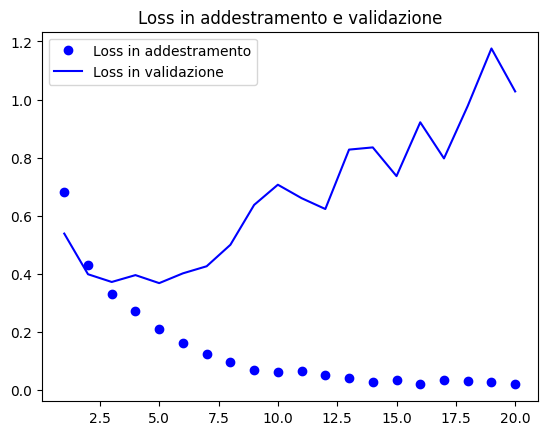

In [ ]:
plot_results(history_model1)

Si osserva un forte overfitting del modello, il quale interviene fin dalle prime epoche. È infatti particolarmente accentuato l'aumento del valore della Loss Function sul validation set, al quale si accompagna uno stallo delle performance di accuratezza.

Si valutano ora le performance sul test set con model.evaluate:

In [ ]:
model1.evaluate(test_generator, verbose = 1) # Valutazione su test generator. Verbose 1 permette di monitorare processo e relativi risultati. Restituisce i valori delle metriche in lista.

100/100 [==============================] - 11s 112ms/step - loss: 1.0922 - accuracy: 0.8630 - precision_4: 0.8632 - recall_4: 0.8624


[1.0921744108200073, 0.863035261631012, 0.8632209300994873, 0.86240553855896]

Si produce una confusion matrix con i risultati del metodo model.predict:

In [ ]:
def generate_conf_matrix(model, test_generator): # Genera una confusion matrix
	true_labels = test_generator.classes # Estrae gli indici delle classi
	predictions = np.argmax(model.predict(test_generator), axis=-1) # Effettua una prediction sulle immagini nel test set
	conf_matrix = metrics.confusion_matrix(true_labels, predictions) # Crea la confusion matrix
	return conf_matrix

def plot_conf_matrix(conf_matrix): # Esegue il plot della confusion matrix desiderata
	cm_display = metrics.ConfusionMatrixDisplay(conf_matrix)
	cm_display.plot(cmap=plt.cm.Blues) # Seleziona la palette di colori
	plt.show()

def calc_accuracy(cm): # Ricalcola manualmente l'accuracy sul test set
	total = cm.sum() # Somma totale dei valori
	true_pred = cm.diagonal().sum() # Somma dei valori sulla diagonale (classificazioni corrette)
	accuracy = true_pred / total # Calcolo accuracy come rapporto
	print("Accuracy on test set:", accuracy)

100/100 [==============================] - 9s 89ms/step


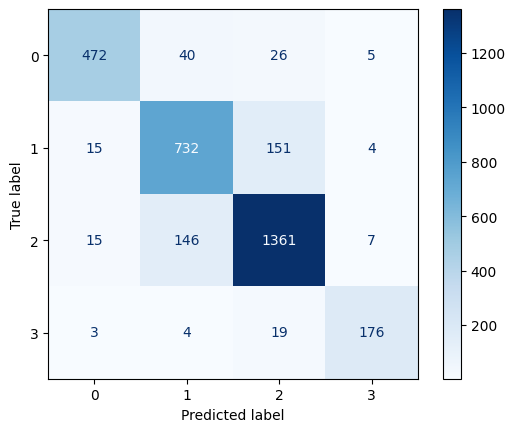

Accuracy on test set: 0.8630352644836272


In [ ]:
test_generator.reset()
cm_model1 = generate_conf_matrix(model1, test_generator)
plot_conf_matrix(cm_model1)
calc_accuracy(cm_model1)

Accuracy, precision e recall sono tutte sull'86%. Precision (Tp/(Tp+Fp)) e Recall (Tp/(Tp+Fn)) sono entrambe restituite in maniera aggregata tra le quattro classi. Entrando nel dettaglio, si osserva una precisione elevata per la classe 0 (Covid) pari a circa 0.93, 0.91 per la classe 3, 0.87 per la classe 2 e circa 0.80 per la classe 1. Nonostante sia la classe meno rappresentata, la classe 3 (Viral Pneumonia, 1345 osservazioni) registra una precisione nella classificazione più alta rispetto a quella per le prime due classi per rappresentanza, vale a dire Lung Opacity (classe 1) e Normal (classe 2). Questo potrebbe essere dovuto ad un'eventuale somiglianza tra queste ultime due classi.

Si testa il modello implementando il parametro padding = 'same'. Questo dovrebbe limitare la riduzione della dimensionalità nei livelli convoluzionali, ottenendo delle feature map di pari dimensione rispetto alle immagini in ingresso nel livello. Questo dovrebbe aiutare a preservare l'informazione ai bordi dell'immagine, il che può tornare utile se alcune radiografie presentano nei bordi alcune porzioni di tessuto polmonare nelle quali si registrano delle lesioni utili al riconoscimento della malattia.

In [ ]:
model1_pad = tf.keras.models.Sequential([
			tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape=(width, height, 1)),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(256, activation='relu'),
			tf.keras.layers.Dense(num_classes, activation='softmax')
		])
print("\n",model1_pad.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 290, 290, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 145, 145, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 145, 145, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 72, 72, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 128)     

In [ ]:
model1_pad.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
history_model1_pad = model1_pad.fit(train_generator, epochs = 20, validation_data = validation_generator)

Epoch 1/20
450/450 [==============================] - 68s 146ms/step - loss: 0.6512 - accuracy: 0.7397 - precision_1: 0.7941 - recall_1: 0.6614 - val_loss: 0.4800 - val_accuracy: 0.8190 - val_precision_1: 0.8383 - val_recall_1: 0.8001
Epoch 2/20
450/450 [==============================] - 61s 136ms/step - loss: 0.3809 - accuracy: 0.8543 - precision_1: 0.8638 - recall_1: 0.8419 - val_loss: 0.3878 - val_accuracy: 0.8526 - val_precision_1: 0.8598 - val_recall_1: 0.8440
Epoch 3/20
450/450 [==============================] - 64s 143ms/step - loss: 0.2966 - accuracy: 0.8856 - precision_1: 0.8921 - recall_1: 0.8796 - val_loss: 0.3023 - val_accuracy: 0.8857 - val_precision_1: 0.8902 - val_recall_1: 0.8815
Epoch 4/20
450/450 [==============================] - 61s 136ms/step - loss: 0.2274 - accuracy: 0.9159 - precision_1: 0.9195 - recall_1: 0.9127 - val_loss: 0.3207 - val_accuracy: 0.8852 - val_precision_1: 0.8886 - val_recall_1: 0.8807
Epoch 5/20
450/450 [==============================] - 61s 13

In [ ]:
save_checkpoint(model1_pad, "/content/drive/MyDrive/Colab/checkpoints/model1_pad_checkpoint.ckpt")

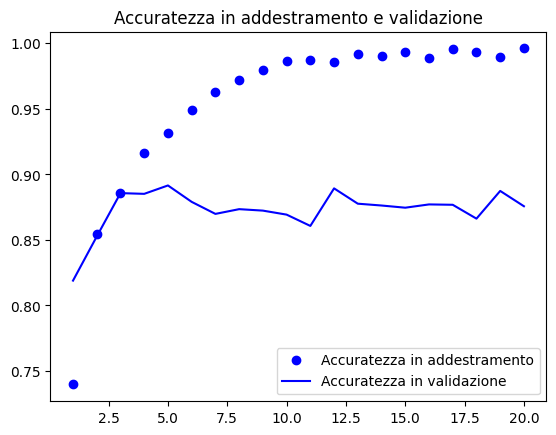

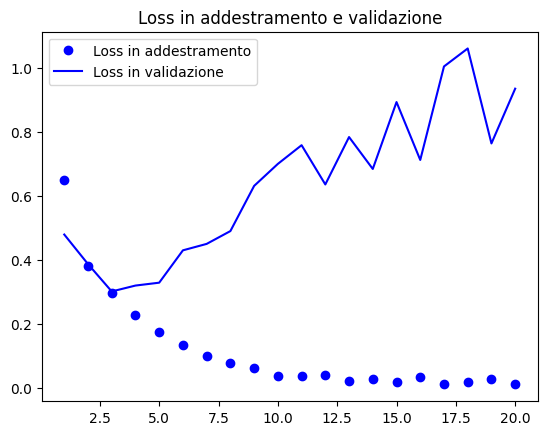

In [ ]:
plot_results(history_model1_pad)

In [ ]:
model1_pad.evaluate(test_generator, verbose = 1)

100/100 [==============================] - 10s 104ms/step - loss: 0.9591 - accuracy: 0.8744 - precision_1: 0.8755 - recall_1: 0.8744


[0.9591109752655029, 0.874370276927948, 0.875472903251648, 0.874370276927948]

100/100 [==============================] - 11s 104ms/step


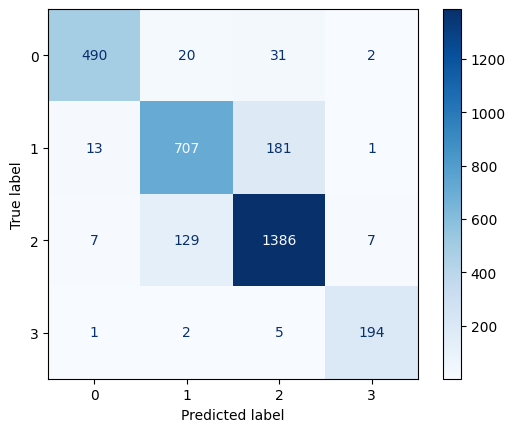

Accuracy on test set: 0.8743702770780857


In [ ]:
test_generator.reset()
cm_model1_pad = generate_conf_matrix(model1_pad, test_generator)
plot_conf_matrix(cm_model1_pad)
calc_accuracy(cm_model1_pad)

Si è ottenuto un miglioramento dell'accuracy di circa un punto percentuale sul test set. Si decide di mantenere il padding = 'same'. Precision e recall presentano lo stesso pattern visto in precedenza, seguendo di pari passo l'aumento dell'accuratezza di circa un punto percentuale.

### MIGLIORAMENTO DELLE PERFORMANCE: DROPOUT

Si vuole osservare quanto migliorano le performance inserendo alcuni livelli di dropout. Questi dovrebbero aiutare a ridurre l'overfitting. Agiscono sui neuroni dello strato sul quale sono applicati andando a disattivarne alcuni, per una quota corrispondente al rateo indicato come argomento.


Si predispone dunque un nuovo modello che presenta gli stessi parametri del precedente e, in aggiunta, alcuni livelli di dropout.
Questi sono stati collocati dopo ciascuno strato convoluzionale e dopo il primo livello Dense. Nel secondo caso, la scelta è motivata dal fatto che i livelli densamente connessi tendono ad avere un elevato numero di parametri, il che li rende particolarmente suscettibili all'overfitting.

In [ ]:
model1_edit = tf.keras.models.Sequential([
			tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape=(width, height, 1)),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3), # Valori tipici sono compresi tra 0.1 e 0.5, ho dunque deciso di adottare una via di mezzo
			tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(256, activation='relu'),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Dense(num_classes, activation='softmax')
		])

print("\n",model1_edit.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 290, 290, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 145, 145, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 145, 145, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 145, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 72, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 72, 72, 64)        0

In [ ]:
model1_edit.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
history_model1_edit = model1_edit.fit(train_generator, epochs = 20, validation_data = validation_generator)

Epoch 1/20
450/450 [==============================] - 103s 190ms/step - loss: 0.8789 - accuracy: 0.6567 - precision: 0.7338 - recall: 0.5293 - val_loss: 0.5896 - val_accuracy: 0.7661 - val_precision: 0.8093 - val_recall: 0.7011
Epoch 2/20
450/450 [==============================] - 82s 183ms/step - loss: 0.5368 - accuracy: 0.7947 - precision: 0.8223 - recall: 0.7575 - val_loss: 0.5186 - val_accuracy: 0.8217 - val_precision: 0.8587 - val_recall: 0.7506
Epoch 3/20
450/450 [==============================] - 92s 203ms/step - loss: 0.4260 - accuracy: 0.8343 - precision: 0.8488 - recall: 0.8150 - val_loss: 0.4310 - val_accuracy: 0.8390 - val_precision: 0.8560 - val_recall: 0.8215
Epoch 4/20
450/450 [==============================] - 92s 205ms/step - loss: 0.3834 - accuracy: 0.8514 - precision: 0.8646 - recall: 0.8369 - val_loss: 0.3899 - val_accuracy: 0.8543 - val_precision: 0.8701 - val_recall: 0.8323
Epoch 5/20
450/450 [==============================] - 91s 202ms/step - loss: 0.3282 - accur

In [ ]:
save_checkpoint(model1_edit, "/content/drive/MyDrive/Colab/checkpoints/model1_edit_checkpoint.ckpt")

Si esegue la comparazione dei risultati dei due modelli senza e con dropout:

In [ ]:
def plot_compare_results(history1, history2): # Estensione della funzione precedente, ma effettua il plot dei risultati per lo storico di due fit assieme
	accuracy1 = history1.history["accuracy"]
	val_accuracy1 = history1.history["val_accuracy"]
	accuracy2 = history2.history["accuracy"]
	val_accuracy2 = history2.history["val_accuracy"]

	loss1 = history1.history["loss"]
	val_loss1 = history1.history["val_loss"]
	loss2 = history2.history["loss"]
	val_loss2 = history2.history["val_loss"]

	epochs = range(1, len(accuracy1) + 1)

	plt.plot(epochs, accuracy1, "ro", label="Accuratezza in addestramento modello 1")
	plt.plot(epochs, val_accuracy1, "r", label="Accuratezza in validazione modello 1")
	plt.plot(epochs, accuracy2, "go", label="Accuratezza in addestramento modello 2")
	plt.plot(epochs, val_accuracy2, "g", label="Accuratezza in validazione modello 2")
	plt.title("Confronto dell'accuratezza in addestramento e validazione")
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss1, "ro", label="Loss in addestramento modello 1")
	plt.plot(epochs, val_loss1, "r", label="Loss in validazione modello 1")
	plt.plot(epochs, loss2, "go", label="Loss in addestramento modello 2")
	plt.plot(epochs, val_loss2, "g", label="Loss in validazione modello 2")
	plt.title("Confronto della perdita in addestramento e validazione")
	plt.legend()

	plt.show()

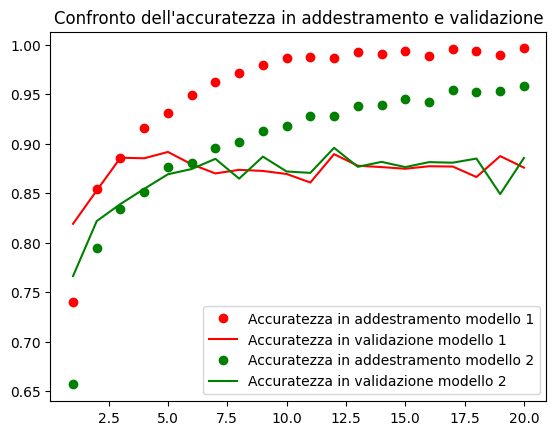

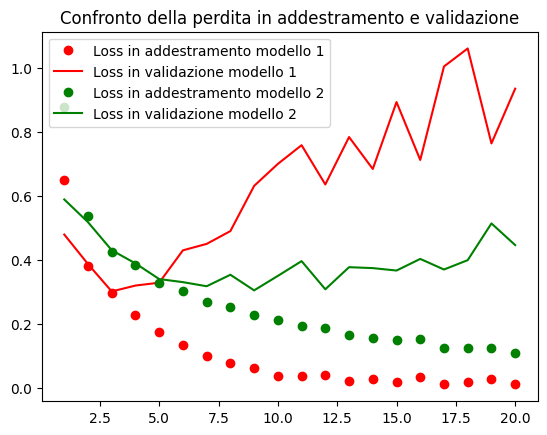

In [ ]:
plot_compare_results(history_model1_pad, history_model1_edit)

In [ ]:
model1_edit.evaluate(test_generator)

100/100 [==============================] - 12s 119ms/step - loss: 0.4553 - accuracy: 0.8725 - precision: 0.8742 - recall: 0.8709


[0.45531389117240906,
 0.872481107711792,
 0.8742098808288574,
 0.8709068298339844]

100/100 [==============================] - 10s 103ms/step


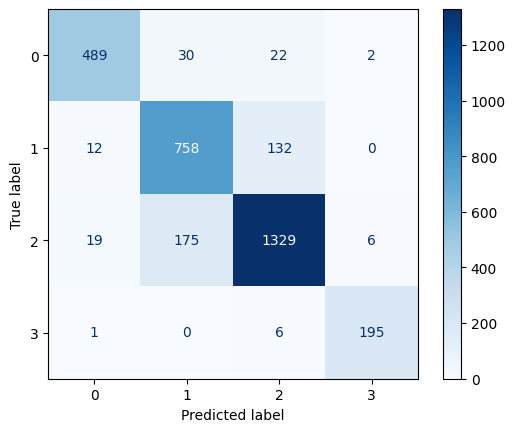

Accuracy on test set: 0.8724811083123426


In [ ]:
test_generator.reset()
cm_model1_edit = generate_conf_matrix(model1_edit, test_generator)
plot_conf_matrix(cm_model1_edit)
calc_accuracy(cm_model1_edit)

Dal grafico appare che l'overfitting è stato leggermente ridotto. Le curve di training e validation accuracy (in verde) appaiono infatti più vicine tra loro rispetto a quelle del modello precedente (in rosso). Anche il valore della loss function del modello con dropout risulta più vicina a quella del training set rispetto a quanto si osserva nel modello senza dropout.

Questo dovrebbe aumentare il potenziale del modello, rendendolo meno suscettibile all'overfitting nel caso di training più lunghi.

## MODELLO 2

Come seconda alternativa, si intende proporre una variante del modello precedente aggiungendo un livello convoluzionale per ogni strato.
L'architettura presenta dunque, per ogni strato, due livelli convoluzionali impilati, seguiti da MaxPooling e Dropout:

In [ ]:
model2 = tf.keras.models.Sequential([
			tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape=(width, height, 1)),
			tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(256, activation='relu'),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Dense(num_classes, activation='softmax')
		])

print("\n",model2.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 290, 290, 32)      320       
                                                                 
 conv2d_41 (Conv2D)          (None, 290, 290, 32)      9248      
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 145, 145, 32)     0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 145, 145, 32)      0         
                                                                 
 conv2d_42 (Conv2D)          (None, 145, 145, 64)      18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 145, 145, 64)      36928     
                                                     

Il numero di parametri aumenta leggermente, in quanto la rete ha una maggiore complessità. Ci si aspetta dunque un maggiore sforzo computazionale, traducibile in un conseguente incremento nel tempo necessario per l'addestramento.

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
history_model2 = model2.fit(train_generator, epochs = 20, validation_data = validation_generator)

Epoch 1/20
450/450 [==============================] - 168s 350ms/step - loss: 0.8666 - accuracy: 0.6436 - precision_3: 0.7325 - recall_3: 0.5117 - val_loss: 0.6917 - val_accuracy: 0.7164 - val_precision_3: 0.7708 - val_recall_3: 0.6407
Epoch 2/20
450/450 [==============================] - 143s 317ms/step - loss: 0.5779 - accuracy: 0.7754 - precision_3: 0.8091 - recall_3: 0.7236 - val_loss: 0.5039 - val_accuracy: 0.8287 - val_precision_3: 0.8597 - val_recall_3: 0.7739
Epoch 3/20
450/450 [==============================] - 144s 319ms/step - loss: 0.4369 - accuracy: 0.8330 - precision_3: 0.8507 - recall_3: 0.8121 - val_loss: 0.4582 - val_accuracy: 0.8309 - val_precision_3: 0.8452 - val_recall_3: 0.8151
Epoch 4/20
450/450 [==============================] - 142s 316ms/step - loss: 0.3733 - accuracy: 0.8585 - precision_3: 0.8703 - recall_3: 0.8444 - val_loss: 0.4315 - val_accuracy: 0.8398 - val_precision_3: 0.8524 - val_recall_3: 0.8284
Epoch 5/20
450/450 [==============================] - 14

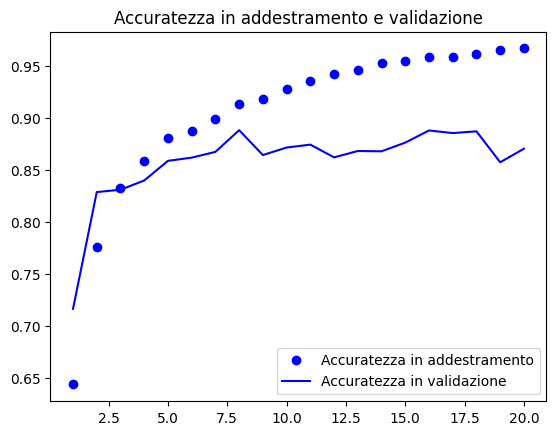

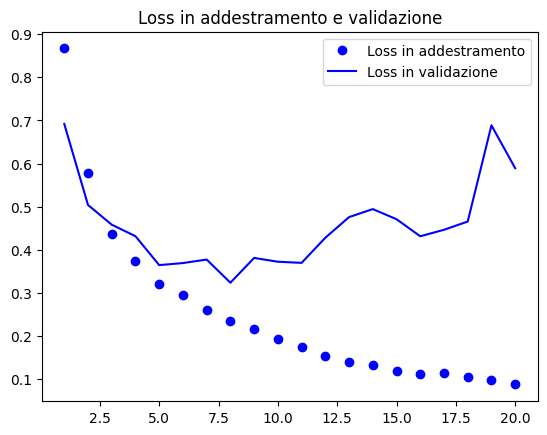

In [ ]:
plot_results(history_model2)

In [ ]:
model2.evaluate(test_generator, verbose = 1)

100/100 [==============================] - 10s 104ms/step - loss: 0.5731 - accuracy: 0.8709 - precision_3: 0.8722 - recall_3: 0.8703


[0.5731310248374939,
 0.8709068298339844,
 0.8721994161605835,
 0.8702771067619324]

100/100 [==============================] - 10s 97ms/step


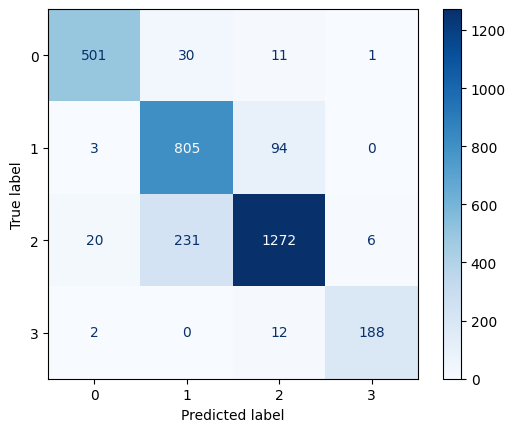

Accuracy on test set: 0.8709068010075567


In [ ]:
test_generator.reset()
cm_model2 = generate_conf_matrix(model2, test_generator)
plot_conf_matrix(cm_model2)
calc_accuracy(cm_model2)

Il tempo necessario per l'addestramento risulta abbastanza dilatato. Tuttavia, questa estensione non sembra migliorare le performance registrate con il modello 1. Oltre all'accuracy, rimangono infatti in linea anche precision e recall globali.

## MODELLO VGG16: TRANSFER LEARNING

Si vogliono valutare le prestazioni di un modello preaddestrato sul dataset oggetto di analisi. La scelta è ricaduta sul modello VGG16.

Il modello prevede un input codificato in RGB. Sebbene in precedenza sia stata preferita una codifica ad un canale in scala di grigi, mantenendo quella originale delle immagini di partenza, in questo caso si predispone un preprocessing dedicato per poter elaborare le immagini con il modello preaddestrato.

Si procede dunque alla creazione di apposite funzioni per il preprocessing a 3 canali:

In [ ]:
train_data_dir = r"/content/COVID-19_Radiography_Dataset" # Path del training set
test_data_dir = r"/content/COVID-19_Radiography_Testset" # Path del test set

def generate_train_data_3c(path):
	np.random.seed(10)
	datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, validation_split = 0.2)
	train_generator = datagen.flow_from_directory(
		path,
		batch_size=batch_size,
 		class_mode='categorical',
		target_size=(height, width),
		subset='training',
		color_mode="rgb"
    )

	validation_generator = datagen.flow_from_directory(
		path,
		batch_size=batch_size,
		class_mode='categorical',
		target_size=(height, width),
		subset='validation',
		color_mode="rgb"
	)
	return train_generator, validation_generator

def generate_test_data_3c(path):
	datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
	test_generator = datagen.flow_from_directory(
		path,
		batch_size=batch_size,
 		class_mode='categorical',
		target_size=(height, width),
		color_mode="rgb",
		shuffle=False
    )
	return test_generator

In [ ]:
height, width = 290, 290 # Dimensioni immagine
batch_size = 32 # Dimensione del batch

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_generator_3c, validation_generator_3c = generate_train_data_3c(train_data_dir)
test_generator_3c = generate_test_data_3c(test_data_dir)

num_classes = train_generator_3c.num_classes
class_labels = list(train_generator_3c.class_indices.keys())
print("Etichette:", class_labels)

Found 14393 images belonging to 4 classes.
Found 3596 images belonging to 4 classes.
Found 3176 images belonging to 4 classes.
Etichette: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


Si scarica il modello preaddestrato da Tensorflow:

In [ ]:
vgg16 = tf.keras.applications.vgg16.VGG16(input_shape= (290,290,3), include_top=False, weights='imagenet') # Si esclude la parte terminale dei livelli densamente connessi

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 290, 290, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 290, 290, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 290, 290, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 145, 145, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 145, 145, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 145, 145, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 72, 72, 128)       0     

È stato caricato il modello escludendo gli ultimi livelli dedicati alla classificazione.

Volendo valutare le prestazioni del modello in transfer learning, si congelano tutti gli strati convoluzionali:

In [ ]:
for layer in vgg16.layers: # Per ogni livello del modello, si imposta come non addestrabile
    layer.trainable = False

Si aggiungono un livello Flatten e due livelli Dense, in modo da poter ottenere un output coerente con il task da risolvere. È stato inserito anche un livello di Dropout dopo il livello Dense principale, in modo da limitare l'overfitting:

In [ ]:
x = vgg16.output # Si parte dall'output degli strati convoluzionali preaddestrati
x = tf.keras.layers.Flatten()(x) # Si aggiunge un livello flatten
x = tf.keras.layers.Dense(256, activation = 'ReLU')(x) # Si aggiunge uno strato dense
x = tf.keras.layers.Dropout(0.4)(x) # Dropout leggermente più consistente rispetto ai casi precedenti, per combattere ulteriormente l'overfitting
output = tf.keras.layers.Dense(num_classes, activation = 'sigmoid')(x) # Livello dense terminale con attivazione sigmoid per la classificazione

model3 = tf.keras.models.Model(inputs = vgg16.input , outputs = output)

In [ ]:
model3.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 290, 290, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 290, 290, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 290, 290, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 145, 145, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 145, 145, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 145, 145, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 72, 72, 128)       0  

Si procede infine al fit del modello e alla sua valutazione delle performance:

In [ ]:
model3.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy", Precision(), Recall()])

train_generator_3c.reset()
history_model3 = model3.fit(train_generator_3c, epochs = 20, validation_data = validation_generator_3c)

Epoch 1/20
450/450 [==============================] - 129s 282ms/step - loss: 0.7865 - accuracy: 0.7559 - precision_10: 0.3998 - recall_10: 0.8767 - val_loss: 0.4871 - val_accuracy: 0.8109 - val_precision_10: 0.3859 - val_recall_10: 0.9360
Epoch 2/20
450/450 [==============================] - 131s 292ms/step - loss: 0.4639 - accuracy: 0.8201 - precision_10: 0.4103 - recall_10: 0.9378 - val_loss: 0.3631 - val_accuracy: 0.8763 - val_precision_10: 0.4142 - val_recall_10: 0.9830
Epoch 3/20
450/450 [==============================] - 133s 295ms/step - loss: 0.4300 - accuracy: 0.8281 - precision_10: 0.4110 - recall_10: 0.9515 - val_loss: 0.3003 - val_accuracy: 0.8971 - val_precision_10: 0.4306 - val_recall_10: 0.9967
Epoch 4/20
450/450 [==============================] - 135s 300ms/step - loss: 0.4518 - accuracy: 0.8079 - precision_10: 0.4099 - recall_10: 0.9488 - val_loss: 0.2988 - val_accuracy: 0.8943 - val_precision_10: 0.4132 - val_recall_10: 0.9969
Epoch 5/20
450/450 [====================

In [ ]:
save_checkpoint(model3, "/content/drive/MyDrive/Colab/checkpoints/model3_checkpoint.ckpt")

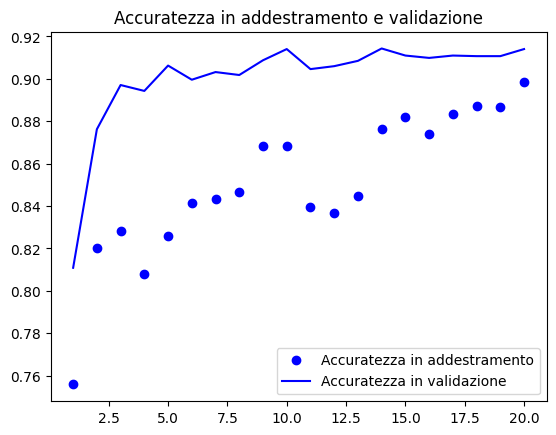

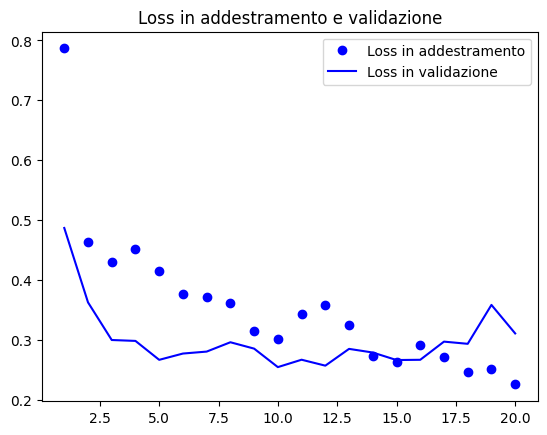

In [ ]:
plot_results(history_model3)

In [ ]:
model3.evaluate(test_generator_3c, verbose = 1)

100/100 [==============================] - 22s 219ms/step - loss: 0.3020 - accuracy: 0.9178 - precision_10: 0.5564 - recall_10: 0.9896


[0.3019810914993286,
 0.9178211688995361,
 0.5563816428184509,
 0.9896095991134644]

100/100 [==============================] - 23s 228ms/step


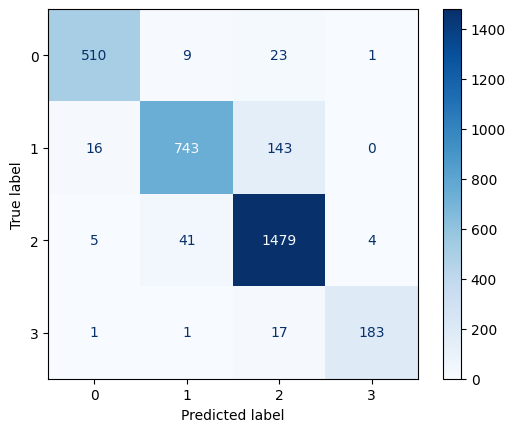

Accuracy on test set: 0.9178211586901763


In [ ]:
test_generator_3c.reset()
cm_model3 = generate_conf_matrix(model3, test_generator_3c)
plot_conf_matrix(cm_model3)
calc_accuracy(cm_model3)

Rispetto ai modelli precedenti, Vgg16 possiede evidenti capacità di generalizzazione, restituendo un'accuratezza superiore sia sul validation set che sul test set.

Presenta piuttosto dei risultati quasi anomali, specialmente se confrontati con le architetture precedenti. Infatti, su training test risultano valori di accuracy più bassi rispetto a quelli registrati sul validation set e, infine, rispetto all'accuracy sul test set. Il fenomeno appare particolarmente evidente confrontando le curve di accuracy del grafico soprastante.

Inoltre, nonostane l'ottima accuratezza, si registra un'anomalia nella precision globale: in questo caso, nonostante la buona precisione calcolabile per ogni classe individualmente (0.96, 0.93, 0.88, 0.97), il valore ottenuto nel calcolo risulta particolarmente basso (0.55). Questo potrebbe essere dovuto a qualche difficoltà nel calcolo interno della metrica applicata a questo modello, in quanto i valori riportati per i due precedenti risultava essere in linea con i valori calcolabili manualmente. Mentre la precision globale appare enormemente sottostimata, la recall sembra essere leggermente sovrastimata.

## MODELLO VGG16: FINE TUNING

Si procede ad effettuare il fine tuning del modello, scongelando gli ultimi 4 livelli (3 livelli convoluzionali, 1 livello di pooling), i quali compongono l'ultimo strato convoluzionale prima dei livelli densamente connesi. L'obiettivo è verificare se, addestrando l'ultimo blocco convoluzionale, è possibile incrementare le performance del modello.

In [ ]:
vgg16 = tf.keras.applications.vgg16.VGG16(input_shape= (290,290,3), include_top=False, weights='imagenet') # Si ricarica il modello di partenza
vgg16.trainable = True # L'intera architettura viene impostata su addestrabile
for layer in vgg16.layers[:-4]: # Si selezionano tutti i livelli tranne gli ultimi 4 come non addestrabili
    layer.trainable = False

In [ ]:
# Si mantiene la stessa struttura terminale
x = vgg16.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation = 'ReLU')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

model3_unfrozen = tf.keras.models.Model(inputs = vgg16.input , outputs = output)

In [ ]:
# I parametri addestrabili aumentano
model3_unfrozen.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 290, 290, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 290, 290, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 290, 290, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 145, 145, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 145, 145, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 145, 145, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 72, 72, 128)       0  

In [ ]:
model3_unfrozen.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy", Precision(), Recall()])

train_generator_3c.reset()
history_model3_unfrozen = model3_unfrozen.fit(train_generator_3c, epochs = 20, validation_data = validation_generator_3c)

Epoch 1/20
450/450 [==============================] - 147s 318ms/step - loss: 0.9062 - accuracy: 0.6114 - precision_7: 0.3924 - recall_7: 0.9047 - val_loss: 0.6316 - val_accuracy: 0.7647 - val_precision_7: 0.4575 - val_recall_7: 0.9558
Epoch 2/20
450/450 [==============================] - 142s 315ms/step - loss: 0.5005 - accuracy: 0.8105 - precision_7: 0.4409 - recall_7: 0.9846 - val_loss: 0.3929 - val_accuracy: 0.8515 - val_precision_7: 0.4506 - val_recall_7: 0.9903
Epoch 3/20
450/450 [==============================] - 148s 328ms/step - loss: 0.3298 - accuracy: 0.8813 - precision_7: 0.4403 - recall_7: 0.9946 - val_loss: 0.3420 - val_accuracy: 0.8754 - val_precision_7: 0.4401 - val_recall_7: 0.9894
Epoch 4/20
450/450 [==============================] - 163s 362ms/step - loss: 0.2514 - accuracy: 0.9127 - precision_7: 0.4559 - recall_7: 0.9962 - val_loss: 0.3027 - val_accuracy: 0.9013 - val_precision_7: 0.4547 - val_recall_7: 0.9928
Epoch 5/20
450/450 [==============================] - 14

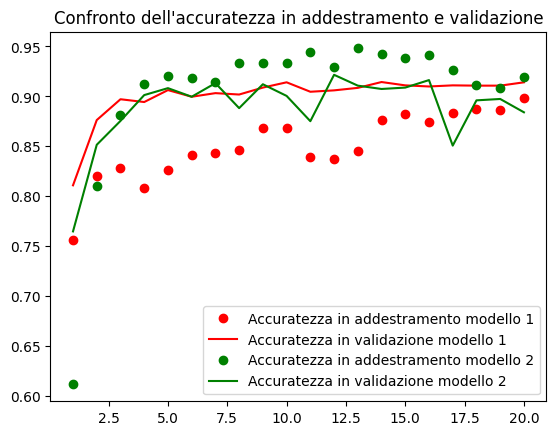

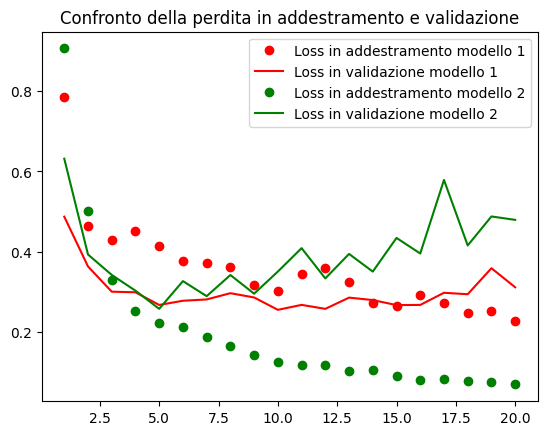

In [ ]:
plot_compare_results(history_model3, history_model3_unfrozen)

In [ ]:
model3_unfrozen.evaluate(test_generator_3c, verbose = 1)

100/100 [==============================] - 22s 220ms/step - loss: 0.5160 - accuracy: 0.8687 - precision_7: 0.5435 - recall_7: 0.9906


[0.5160084366798401, 0.86870276927948, 0.5435383319854736, 0.99055415391922]

Si osserva che, con il fine tuning, sono diminuite le performance sia sul validation set che sul test set, mentre è aumentato l'overfitting. Inoltre, è aumentata la variabilità dell'errore sul validation set.

Sembra che gli ultimi strati convoluzionali, usando i pesi preaddestrati, siano in grado di generalizzare sufficientemente bene, restituendo discrete performance senza necessitare del fine tuning, il quale contribuisce invece al peggioramento delle performance, almeno per quanto riguarda lo scongelamento degll'ultimo strato convoluzionale.

## **DATA AUGMENTATION**

Per potenziare le capacità di generazione dei modelli e combattere ulteriormente l'overfitting, verrà eseguita una data augmentation sui dati di addestramento.

Si tratta di una metodologia che consente di aumentare i dati a disposizione per il training apportando variazioni ai dati di partenza, al fine di non mostrare sempre le stesse immagini al modello e cercare di aumentarne le capacità predittive.

Si valuta l'impatto di questa tecnica su overfitting e accuracy, applicandola al primo modello.

Di seguito alcuni esempi delle possibili tecniche da implementare:

In [ ]:
from PIL import ImageEnhance

def plot_augmentation(path):
	image = Image.open(path)
	rotated_image = image.rotate(10)
	vertical_flip = image.transpose(Image.FLIP_TOP_BOTTOM)
	horizontal_flip = image.transpose(Image.FLIP_LEFT_RIGHT)
	enhanced_brightness = ImageEnhance.Brightness(image).enhance(1.5)
	reduced_brightness = ImageEnhance.Brightness(image).enhance(0.1)

	fig, axs = plt.subplots(1, 6, figsize = (18,18), facecolor='white')

	axs[0].imshow(image, cmap = 'gray')
	axs[0].set_title('Original', color='black')
	axs[0].axis('off')

	axs[1].imshow(rotated_image, cmap = 'gray')
	axs[1].set_title('Rotation', color='black')
	axs[1].axis('off')

	axs[2].imshow(vertical_flip, cmap = 'gray')
	axs[2].set_title('Vertical flip', color='black')
	axs[2].axis('off')

	axs[3].imshow(horizontal_flip, cmap = 'gray')
	axs[3].set_title('Horizontal flip', color='black')
	axs[3].axis('off')

	axs[4].imshow(enhanced_brightness, cmap = 'gray')
	axs[4].set_title('Brightness (+)', color='black')
	axs[4].axis('off')

	axs[5].imshow(reduced_brightness, cmap = 'gray')
	axs[5].set_title('Brightness (-)', color='black')
	axs[5].axis('off')

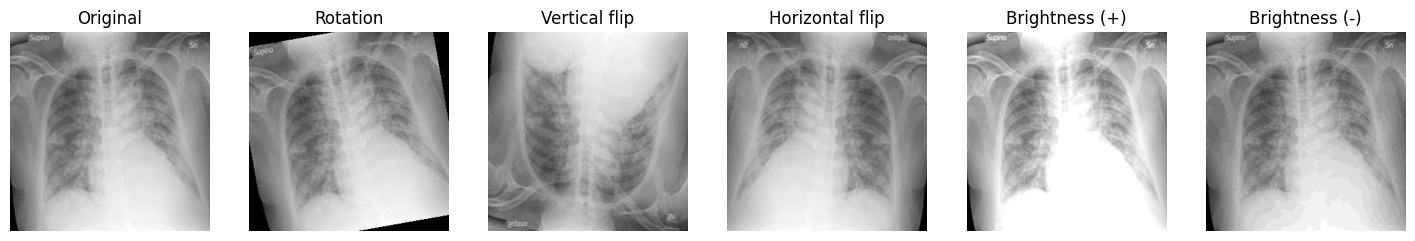

In [ ]:
plot_augmentation(r"/content/COVID-19_Radiography_Dataset/COVID/images/COVID-10.png")

Si valuta la prima architettura proposta, nella sua versione finale (model1_edit):

In [ ]:
model1_edit_aug = tf.keras.models.Sequential([ # Il nome diverso permette di gestire meglio i nomi delle variabili tra un fit e l'altro
			tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape=(width, height, 1)),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(256, activation='relu'),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Dense(num_classes, activation='softmax')
		])

print("\n",model1_edit_aug.summary())

Si predispongono e si lanciano le funzioni per la creazione di un train generator, indicando i parametri di modifica delle immagini per la data augmentation che sarà effettuata in fase di addestramento.

Si inizia provando solo i flip verticale e orizzontale:

In [ ]:
train_data_dir = r"/content/COVID-19_Radiography_Dataset" # Path del training set

def generate_train_with_augmentation_only_flip(path):
	datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, validation_split = 0.2,
			vertical_flip=True,
			horizontal_flip=True,
			fill_mode='nearest'
		)

	train_generator = datagen.flow_from_directory(
			path,
			batch_size=batch_size,
	 		class_mode='categorical',
			target_size=(height, width),
			subset='training',
			color_mode="grayscale"
	    )

	validation_generator = datagen.flow_from_directory(
			path,
			batch_size=batch_size,
			class_mode='categorical',
			target_size=(height, width),
			subset='validation',
			color_mode="grayscale"
		)

	return train_generator, validation_generator

In [ ]:
height, width = 290, 290
batch_size = 32

train_generator_flip, validation_generator_flip = generate_train_with_augmentation_only_flip(train_data_dir)

Found 14393 images belonging to 4 classes.
Found 3596 images belonging to 4 classes.


In [ ]:
model1_edit_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
train_generator.reset()
history_model1_edit_aug_flip = model1_edit_aug.fit(train_generator_flip, epochs = 30, steps_per_epoch = 200, validation_data = validation_generator_flip)
# L'inserimento del parametro steps per epoch è motivato da ragioni di tempo, in quanto il fit risulterebbe troppo lungo e verrebbero superati i limiti di Colab

Epoch 1/30
200/200 [==============================] - 43s 198ms/step - loss: 1.1133 - accuracy: 0.5291 - precision_2: 0.6434 - recall_2: 0.3059 - val_loss: 1.0794 - val_accuracy: 0.5742 - val_precision_2: 0.8100 - val_recall_2: 0.1304
Epoch 2/30
200/200 [==============================] - 40s 200ms/step - loss: 0.8795 - accuracy: 0.6281 - precision_2: 0.7122 - recall_2: 0.4794 - val_loss: 0.9851 - val_accuracy: 0.6224 - val_precision_2: 0.8658 - val_recall_2: 0.1596
Epoch 3/30
200/200 [==============================] - 39s 195ms/step - loss: 0.8045 - accuracy: 0.6747 - precision_2: 0.7439 - recall_2: 0.5473 - val_loss: 0.9221 - val_accuracy: 0.6349 - val_precision_2: 0.7126 - val_recall_2: 0.3896
Epoch 4/30
200/200 [==============================] - 40s 200ms/step - loss: 0.7258 - accuracy: 0.7075 - precision_2: 0.7673 - recall_2: 0.6209 - val_loss: 1.2473 - val_accuracy: 0.4316 - val_precision_2: 0.4560 - val_recall_2: 0.3281
Epoch 5/30
200/200 [==============================] - 39s 19

In [ ]:
save_checkpoint(model1_edit_aug, "/content/drive/MyDrive/Colab/checkpoints/model1_edit_flip_checkpoint.ckpt")

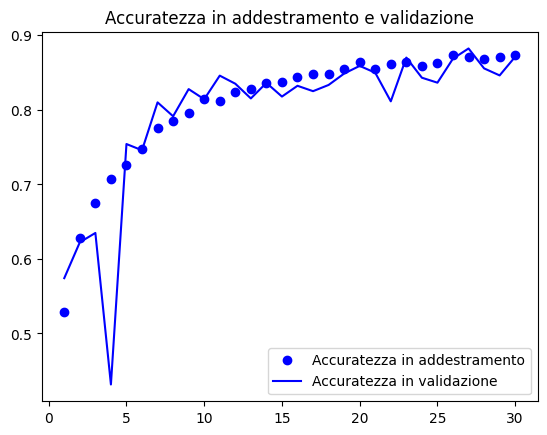

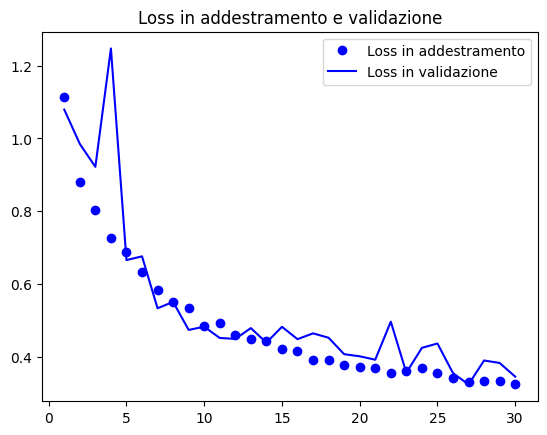

In [ ]:
plot_results(history_model1_edit_aug_flip)

In [ ]:
model1_edit_aug.evaluate(test_generator)

100/100 [==============================] - 9s 89ms/step - loss: 0.3330 - accuracy: 0.8731 - precision_2: 0.8797 - recall_2: 0.8637


[0.33299919962882996, 0.873110830783844, 0.8797305822372437, 0.863664984703064]

100/100 [==============================] - 13s 128ms/step


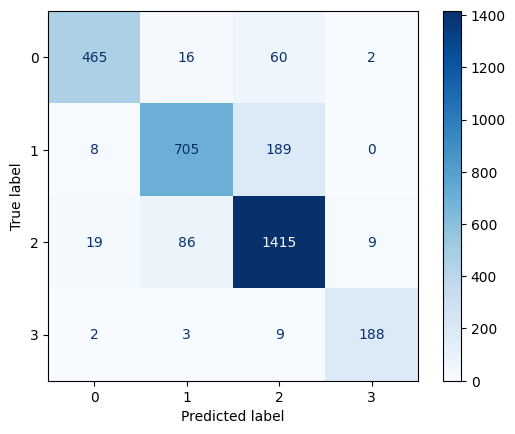

Accuracy on test set: 0.8731108312342569


In [ ]:
test_generator.reset()
cm_model1_edit_flip = generate_conf_matrix(model1_edit_aug, test_generator)
plot_conf_matrix(cm_model1_edit_flip)
calc_accuracy(cm_model1_edit_flip)

Non si notano particolari miglioramenti, almeno nelle prime 30 epoche, dei risultati sul test set. Tuttavia, le curve di train e validation appaiono quasi sovrapposte, segno dell'efficacia dell'aumento dei dati nei confronti dell'overfitting.

I valori di precision per le quattro classi sono, in ordine, 0.94, 0.87, 0.84 e 0.94,mentre per la recall si hanno 0.85, 0.78, 0.92 e 0.94. Nonostante l'aumento dei dati, si registrano ancora difficoltà nell'identificazione delle due classi Lung Opacity (1) e Normal (2), in particolar modo per quanto riguarda il basso valore dei positivi della classe 1 che vengono identificati invece come classe 2.

Si ripete l'esperimento (dopo aver resettato model1_edit_aug) aumentando il numero di epoche. Si intende valutare se, allungando l'addestramento, il modello riesce a migliorare le sue performance.

In [ ]:
model1_edit_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
train_generator.reset()
history_model1_edit_aug_flip = model1_edit_aug.fit(train_generator_flip, epochs = 50, steps_per_epoch = 200, validation_data = validation_generator_flip)

Epoch 1/50
200/200 [==============================] - 42s 192ms/step - loss: 1.0871 - accuracy: 0.5439 - precision_1: 0.6540 - recall_1: 0.3338 - val_loss: 0.9602 - val_accuracy: 0.6082 - val_precision_1: 0.7011 - val_recall_1: 0.3888
Epoch 2/50
200/200 [==============================] - 38s 192ms/step - loss: 0.8603 - accuracy: 0.6438 - precision_1: 0.7140 - recall_1: 0.4924 - val_loss: 0.8777 - val_accuracy: 0.6744 - val_precision_1: 0.8329 - val_recall_1: 0.3993
Epoch 3/50
200/200 [==============================] - 39s 196ms/step - loss: 0.7707 - accuracy: 0.6837 - precision_1: 0.7494 - recall_1: 0.5900 - val_loss: 0.7078 - val_accuracy: 0.7055 - val_precision_1: 0.7791 - val_recall_1: 0.6326
Epoch 4/50
200/200 [==============================] - 40s 200ms/step - loss: 0.6921 - accuracy: 0.7163 - precision_1: 0.7689 - recall_1: 0.6431 - val_loss: 0.6515 - val_accuracy: 0.7556 - val_precision_1: 0.8099 - val_recall_1: 0.6577
Epoch 5/50
200/200 [==============================] - 40s 19

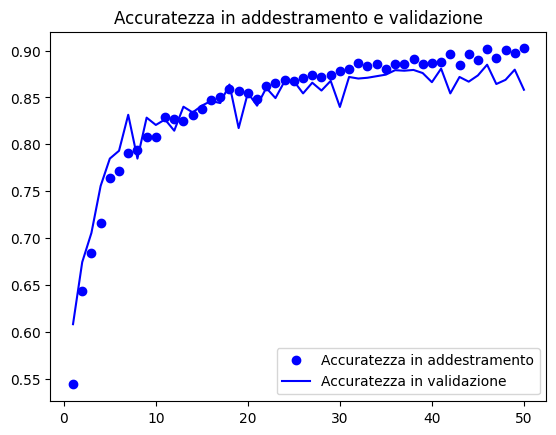

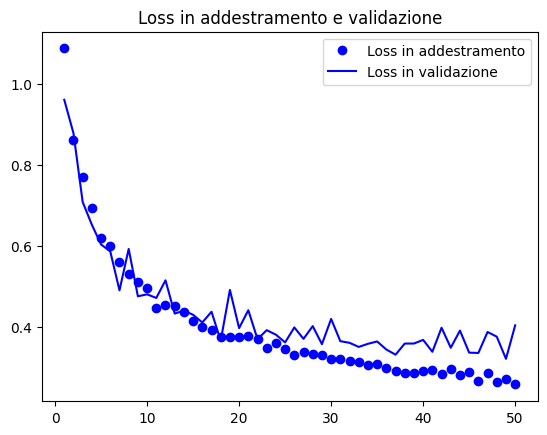

In [ ]:
plot_results(history_model1_edit_aug_flip)

In [ ]:
model1_edit_aug.evaluate(test_generator)

100/100 [==============================] - 8s 81ms/step - loss: 0.3692 - accuracy: 0.8643 - precision_1: 0.8718 - recall_1: 0.8545


[0.36919105052948, 0.864294707775116, 0.8718278408050537, 0.8545340299606323]

100/100 [==============================] - 7s 72ms/step


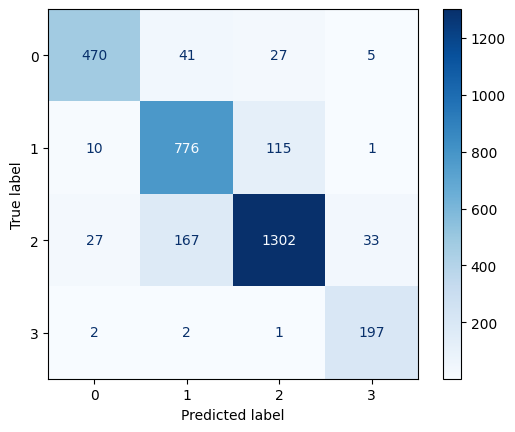

Accuracy on test set: 0.864294710327456


In [ ]:
test_generator.reset()
cm_model1_edit_flip = generate_conf_matrix(model1_edit_aug, test_generator)
plot_conf_matrix(cm_model1_edit_flip)
calc_accuracy(cm_model1_edit_flip)

Non aumentano le prestazioni del modello. Oltre la trentesima epoca, le curve di train e validation iniziano ad allontanarsi. L'accuracy su test set cala di un punto percentuale.

Si decide di affiancare ai flip anche la modifica della luminosità (più e meno 50%) e un rotation range casuale, ampliando il numero di trasformazioni effettuate in fase di training:

In [ ]:
train_data_dir = r"/content/COVID-19_Radiography_Dataset" # Path del training set

def generate_train_with_augmentation(path):
	datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, validation_split = 0.2,
			vertical_flip=True,
			horizontal_flip=True,
			brightness_range=(0.5, 1.5),
			rotation_range=30,
			fill_mode='nearest'
		)

	train_generator = datagen.flow_from_directory(
			path,
			batch_size=batch_size,
	 		class_mode='categorical',
			target_size=(height, width),
			subset='training',
			color_mode="grayscale"
	    )

	validation_generator = datagen.flow_from_directory(
			path,
			batch_size=batch_size,
			class_mode='categorical',
			target_size=(height, width),
			subset='validation',
			color_mode="grayscale"
		)

	return train_generator, validation_generator

In [ ]:
height, width = 290, 290
batch_size = 32

train_generator_aug, validation_generator_aug = generate_train_with_augmentation(train_data_dir)

Found 14393 images belonging to 4 classes.
Found 3596 images belonging to 4 classes.


L'architettura rimane la stessa:

In [ ]:
model1_edit_aug = tf.keras.models.Sequential([
			tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape=(width, height, 1)),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(256, activation='relu'),
			tf.keras.layers.Dropout(0.3),
			tf.keras.layers.Dense(num_classes, activation='softmax')
		])

print("\n",model1_edit_aug.summary())

In [ ]:
model1_edit_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
train_generator.reset()
history_model1_edit_aug = model1_edit_aug.fit(train_generator_aug, epochs = 50, steps_per_epoch = 200, validation_data = validation_generator_aug)

Epoch 1/50
200/200 [==============================] - 114s 486ms/step - loss: 1.1209 - accuracy: 0.5250 - precision: 0.6430 - recall: 0.2783 - val_loss: 1.0022 - val_accuracy: 0.6054 - val_precision: 0.7961 - val_recall: 0.2183
Epoch 2/50
200/200 [==============================] - 95s 478ms/step - loss: 0.9175 - accuracy: 0.6255 - precision: 0.7119 - recall: 0.4707 - val_loss: 0.9135 - val_accuracy: 0.6535 - val_precision: 0.8387 - val_recall: 0.3095
Epoch 3/50
200/200 [==============================] - 92s 461ms/step - loss: 0.8759 - accuracy: 0.6414 - precision: 0.7251 - recall: 0.5064 - val_loss: 0.8441 - val_accuracy: 0.6588 - val_precision: 0.7951 - val_recall: 0.4619
Epoch 4/50
200/200 [==============================] - 102s 512ms/step - loss: 0.8274 - accuracy: 0.6626 - precision: 0.7411 - recall: 0.5378 - val_loss: 0.8028 - val_accuracy: 0.6838 - val_precision: 0.8230 - val_recall: 0.4861
Epoch 5/50
200/200 [==============================] - 92s 460ms/step - loss: 0.7948 - accu

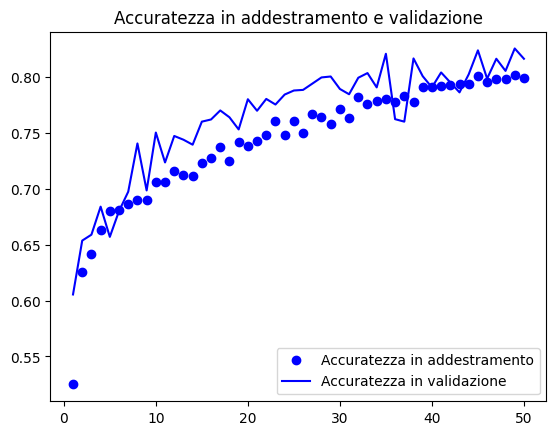

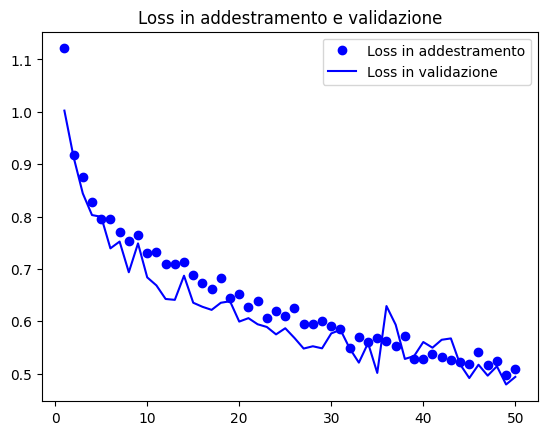

In [ ]:
plot_results(history_model1_edit_aug)

In [ ]:
test_generator.reset()
model1_edit_aug.evaluate(test_generator)

100/100 [==============================] - 10s 95ms/step - loss: 0.4310 - accuracy: 0.8350 - precision: 0.8577 - recall: 0.8082


[0.43098264932632446,
 0.8350126147270203,
 0.857667863368988,
 0.8082493543624878]

100/100 [==============================] - 9s 87ms/step


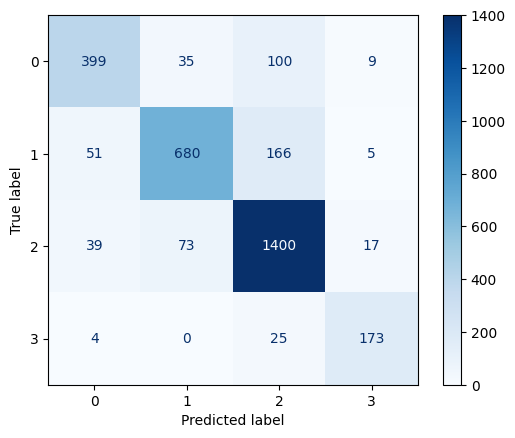

Accuracy on test set: 0.8350125944584383


In [ ]:
test_generator.reset()
cm_model1_edit_aug = generate_conf_matrix(model1_edit_aug, test_generator)
plot_conf_matrix(cm_model1_edit_aug)
calc_accuracy(cm_model1_edit_aug)

Sebbene le curve rimangano quasi sovrapposte, l'aumento di accuracy sul validation set si blocca nelle ultime 15 epoche. Le nuove varianti di data augmentation non sembrano essere particolarmente utili per il caso in esame.

Ad accompagnare la diminuzione dell'accuracy, sia precision che recall calano, registrando valori di osservazioni mal classificate più distribuiti rispetto al caso precedente.

L'aumento dei dati ha dato solo parzialmente i risultati sperati. Ha diminuito l'overfitting, tuttavia non ha garantito un miglioramento dei risultati sul test set, almeno per quanto riguarda le tecniche sperimentate.

# **EXPLAINABLE AI**

Uno dei problemi principali dei modelli di deep learning risulta essere la scarsa intepretabilità dei risultati. Tuttavia, sono state sviluppate alcune tecniche nell'ambito della spiegabilità algoritmica, le quali permettono di "decifrare" come il modello sia arrivato ad una determinata conclusione.

Nel caso in esame, può essere interessante capire quali aree hanno contribuito maggiormente alla determinazione dell'output del modello, dunque quali particolari dell'immagine hanno portato il modello medesimo ad effettuare una determinata classificazione.

Per fare ciò, si utilizza la tecnica GradCAM. Questa permette di generare una mappa di calore sulla base dei pixel in corrispondenza dei quali si registrano gradienti più alti e, dunque, quelli che risultano più rilevanti al fine della determinazione dell'ouput.

Si prende a riferimento il seguente modello, clone del precedente model1_edit:

In [ ]:
model = tf.keras.models.Sequential([
			tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape=(width, height, 1), name = "conv1"), # I livelli sono rinominati per poterli selezionare agevolmente dopo
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name = "maxpool1"),
			tf.keras.layers.Dropout(0.3, name = "drop1"),
			tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same', name = "conv2"),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name = "maxpool2"),
			tf.keras.layers.Dropout(0.3, name = "drop2"),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', name = "conv3"),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name = "maxpool3"),
			tf.keras.layers.Dropout(0.3, name = "drop3"),
			tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', name = "conv4"),
			tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name = "maxpool4"),
			tf.keras.layers.Dropout(0.3, name = "drop4"),
			tf.keras.layers.Flatten(name = "flat_lv"),
			tf.keras.layers.Dense(256, activation='relu', name = "dense1"),
			tf.keras.layers.Dropout(0.3, name = "drop5"),
			tf.keras.layers.Dense(num_classes, activation='softmax', name = "dense2")
		])

print("\n",model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 290, 290, 32)      320       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 145, 145, 32)      0         
                                                                 
 drop1 (Dropout)             (None, 145, 145, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 145, 145, 64)      18496     
                                                                 
 maxpool2 (MaxPooling2D)     (None, 72, 72, 64)        0         
                                                                 
 drop2 (Dropout)             (None, 72, 72, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 72, 72, 128)       7

Si caricano i pesi salvati dopo l'addestramento model1_edit. In alternativa, si può rieseguire un fit del modello.

In [ ]:
model.load_weights("/content/drive/MyDrive/Colab/checkpoints/model1_edit_checkpoint.ckpt")

In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
# history_model = model.fit(train_generator, epochs = 20, validation_data = validation_generator)

Si sceglie un'immagine di esempio sulla quale applicare la mappa di calore. In questo caso, è stato scelto manualmente un caso positivo al Covid-19.

In [ ]:
img_path = r"/content/COVID-19_Radiography_Dataset/COVID/images/COVID-101.png"
img = tf.keras.utils.load_img(img_path, target_size=(290,290,1), color_mode = 'grayscale')

print(img)
array = tf.keras.utils.img_to_array(img)
array = array / 255.0
img_array = np.expand_dims(array, axis=0)

<PIL.Image.Image image mode=L size=290x290 at 0x7FC7B5491C30>


Di seguito, il plot dell'immagine selezionata:

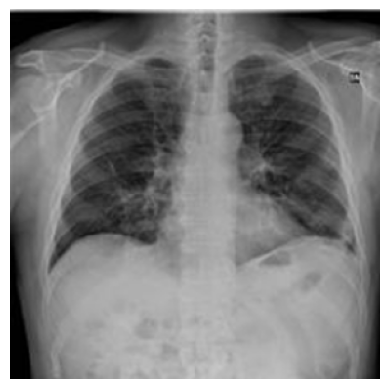

In [ ]:
plt.imshow(tf.keras.utils.load_img(img_path, target_size=(290,290,3)), cmap='gray')
plt.axis('off')
plt.show()

Si esegue un predict per classificare l'immagine utilizzando il modello sopra indicato:

In [ ]:
preds = model.predict(img_array)
formatted_predictions = []
for prediction in preds:
    formatted_prediction = [f'{value:.2f}'.replace('.', ',') for value in prediction] # Si riformattano i valori per renderli più leggibili
    formatted_predictions.append(formatted_prediction)

print("Valori originali:", preds)
print("Probabilità per classe:", formatted_predictions)

1/1 [==============================] - 7s 7s/step
Valori originali: [[9.9365187e-01 2.7636377e-05 6.3199275e-03 6.1563168e-07]]
Probabilità per classe: [['0,99', '0,00', '0,01', '0,00']]


Si ricorda che gli indici di classe sono i seguenti:

*   0: Covid
*   1: Lung Opacity
*   2: Normal
*   3: Viral Pneumonia

Il modello classifica correttamente l'immagine, restituendo come probabilità delle classi Covid (classe 0) al 99% e Normale all'1%.

È necessario divide il modello in corrispondenza dell'ultimo livello convoluzionale. Di seguito vengono restituiti i nomi dei livelli del modello:

In [ ]:
for layer in model.layers:
  if isinstance(layer, (tf.keras.layers.Conv2D)):
    print(layer.name)

conv1
conv2
conv3
conv4


Si procede alla definizione delle funzioni per la generazione e il successivo plot della heatmap tramite GradCAM. Le funzioni sono un porting di quelle presenti nel notebook dedicato presentato nelle sessioni di laboratorio, adeguatamente modificato per l'applicazione nel caso in esame.

In [ ]:
# Come argomenti, sono inseriti manualmente il nome del modello, i nomi dell'ultimo livello convoluzionale, i nomi dei livelli terminali di classificazione e l'immagine in formato array
def define_heatmap(model, last_conv_layer_name, classifier_layer_names, img_array):
    last_conv_layer = model.get_layer(last_conv_layer_name) # Si carica l'ultimo livello convoluzionale dal modello di riferimento
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output) # Si crea un modello con tutti i livelli dall'input all'ultimo convoluzionale

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:]) # Si crea un nuovo modello classificatore, con input di pari forma rispetto all'output dell'ultimo livello convoluzionale
    x = classifier_input
    for layer_name in classifier_layer_names: # Si aggiungono i livelli per la classificazione
      x = model.get_layer(layer_name)(x)
      classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
      last_conv_layer_output = last_conv_layer_model(img_array) # Si registra l'output dell'ultimo livello convoluzionale
      tape.watch(last_conv_layer_output) # Si espone l'output al GradientTape
      preds = classifier_model(last_conv_layer_output) # Si effettua la prediction con il classificatore
      top_pred_index = tf.argmax(preds[0]) # Si estrae l'indice della classe con la maggiore probabiltià, in questo caso 0 (Covid)
      top_class_channel = preds[:, top_pred_index] # Si estrae il canale
    grads = tape.gradient(top_class_channel, last_conv_layer_output) # Si ottengono i valori dei gradienti

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # Si effettua il pooling dei gradienti
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    for i in range(pooled_grads.shape[-1]):
      last_conv_layer_output[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    # Si ottiene la heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def plot_heatmap(heatmap): # Esegue il plot della heatmap
    plt.matshow(heatmap)
    plt.axis("off")

def plot_gradient_cam(img, heatmap, path): # Esegue il plot della combinazione tra immagine di partenza e heatmap
    img = tf.keras.utils.load_img(path)
    img = tf.keras.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = matplotlib.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    plt.imshow(superimposed_img)
    plt.axis("off")

Si salvano i nomi dei livelli di interesse in apposite variabili, per poi richiamare le funzioni precedentemente definite passando tali variabili come argomenti:

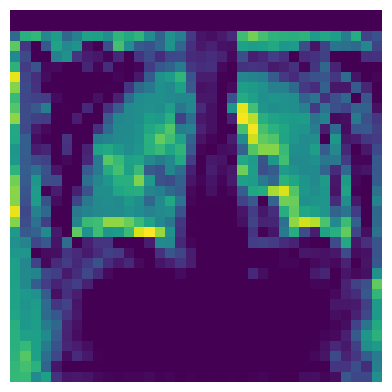

In [ ]:
last_conv_layer_name = 'conv4'
classifier_layer_names = ['maxpool4', 'drop4', 'flat_lv', 'dense1', 'drop5', 'dense2']

heatmap_1 = define_heatmap(model, last_conv_layer_name, classifier_layer_names, img_array)
plot_heatmap(heatmap_1)

Sopra, il plot della heatmap generata. Si nota in particolar modo la forma dei polmoni, con diverse aree accese in alcune parti del tessuto polmonare. Per interpretarla, è necessario sovrapporla all'immagine di partenza, dunque:

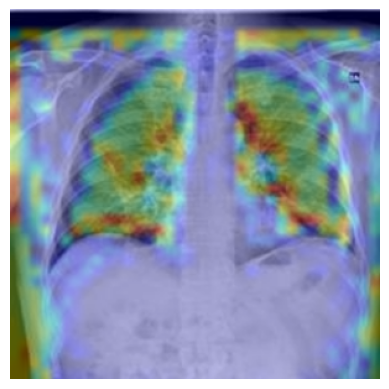

In [ ]:
plot_gradient_cam(img, heatmap_1, img_path)


Per semplificarne la valutazione, si esegue un plot affiancato da quello dell'immagine di partenza:

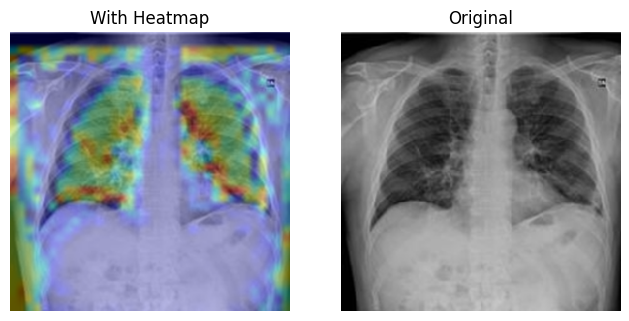

In [ ]:
plt.subplot(1, 2, 1)
plot_gradient_cam(img, heatmap_1, img_path)
plt.title('With Heatmap')

plt.subplot(1, 2, 2)
plt.imshow(tf.keras.utils.load_img(img_path, target_size=(290,290,3)), cmap='gray')
plt.title('Original')

plt.tight_layout()
plt.axis("off")

plt.show()

La heatmap evidenzia specifiche attivazioni attorno agli alveoli (i quali sono simili a delle "ragnatele"), in corrispondenza di quelle che gli specialisti definiscono "opacità", presumibilmente le regioni scure dei polmoni. Queste dovrebbero corrispondere alle lesioni del tessuto polmonare, chiari segni dell'esposizione al Covid-19, le quali possono causare polmoniti e gravi problematiche respiratorie all'individuo.

Per semplificare il richiamo delle funzioni su nuove immagini di esempio, si mette tutto sotto un'unica funzione:

In [ ]:
def generate_heatmap_from_image(model, path, last_conv_layer_name, classifier_layer_names):
  img = tf.keras.utils.load_img(path, target_size=(290,290,1), color_mode = 'grayscale')
  array = tf.keras.utils.img_to_array(img)
  array = array / 255.0
  img_array = np.expand_dims(array, axis=0)

  preds = model.predict(img_array)
  formatted_predictions = []
  for prediction in preds:
      formatted_prediction = [f'{value:.2f}'.replace('.', ',') for value in prediction]
      formatted_predictions.append(formatted_prediction)

  print("\nValori originali:", preds)
  print("Probabilità per classe:", formatted_predictions, "\n")

  heatmap = define_heatmap(model, last_conv_layer_name, classifier_layer_names, img_array)

  plt.subplot(1, 2, 1)
  plt.imshow(tf.keras.utils.load_img(path, target_size=(290,290,3)), cmap='gray')
  plt.axis("off")
  plt.title('Original')

  plt.subplot(1, 2, 2)
  plot_gradient_cam(img, heatmap, path)
  plt.title('Heatmap')

  plt.tight_layout()
  plt.show()

1/1 [==============================] - 0s 39ms/step

Valori originali: [[9.9993443e-01 3.7812396e-07 6.5190448e-05 4.5331402e-11]]
Probabilità per classe: [['1,00', '0,00', '0,00', '0,00']] 



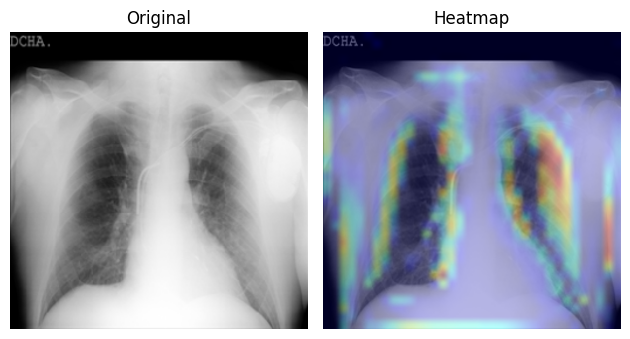

In [ ]:
generate_heatmap_from_image(model, r"/content/COVID-19_Radiography_Testset/COVID/COVID-273.png", last_conv_layer_name, classifier_layer_names)

Immagine correttamente classificata per soggetto con Covid-19. Si osservano delle attivazioni simili alle precedenti attorno agli alveoli, con un'area di attivazione particolarmente rilevante nel polmone sinistro in aggiunta al caso precedente.

1/1 [==============================] - 0s 86ms/step

Valori originali: [[1.5633386e-14 2.0969528e-13 1.0000000e+00 4.7163007e-09]]
Probabilità per classe: [['0,00', '0,00', '1,00', '0,00']] 



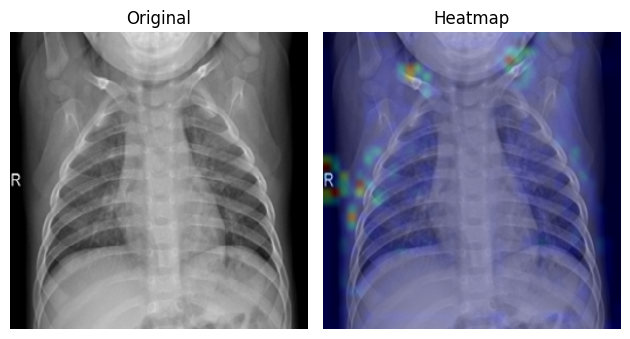

In [ ]:
generate_heatmap_from_image(model, r"/content/COVID-19_Radiography_Testset/Normal/Normal-1000.png", last_conv_layer_name, classifier_layer_names)

Immagine correttamente classificata come normale. Non sono presenti attivazioni sul tessuto polmonare, piuttosto sono localizzate in aree di scarso interesse, come le clavicole.

1/1 [==============================] - 0s 29ms/step

Valori originali: [[2.0638989e-04 9.5663863e-01 4.3154266e-02 7.0921561e-07]]
Probabilità per classe: [['0,00', '0,96', '0,04', '0,00']] 



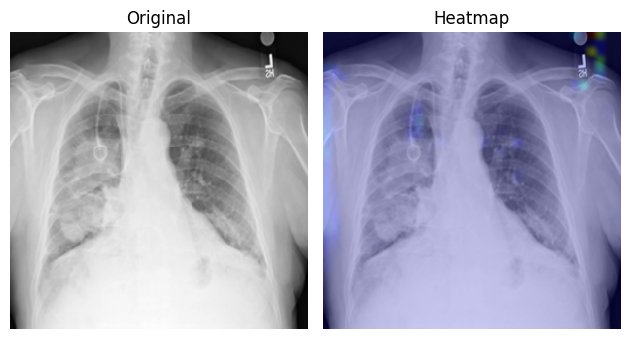

In [ ]:
generate_heatmap_from_image(model, r"/content/COVID-19_Radiography_Testset/Lung_Opacity/Lung_Opacity-17.png", last_conv_layer_name, classifier_layer_names)

Immagine correttamente classificata come opacità polmonare. Molto simile al caso precedente, sono presenti piccole attivazioni nel tessuto polmonare.

1/1 [==============================] - 0s 34ms/step

Valori originali: [[2.8161615e-09 1.2815784e-08 1.5151453e-09 1.0000000e+00]]
Probabilità per classe: [['0,00', '0,00', '0,00', '1,00']] 



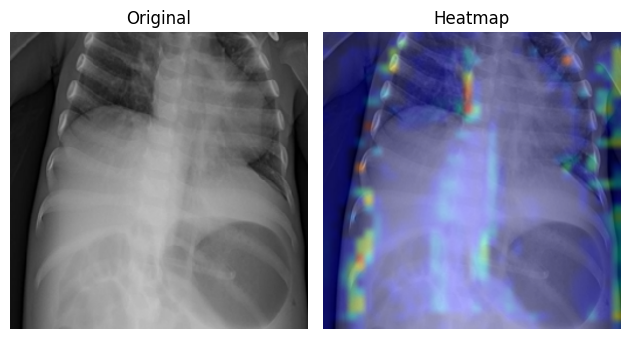

In [ ]:
generate_heatmap_from_image(model, r"/content/COVID-19_Radiography_Testset/Viral Pneumonia/Viral Pneumonia-929.png", last_conv_layer_name, classifier_layer_names)

Immagine correttamente classificata come Viral Pneumonia.
In questo caso, le attivazioni sono localizzate lungo il perimetro della cassa toracica e leggermente sullo sterno.

Alcune classificazioni risultano corrette nonostante non si registrino attivazioni particolarmente accese. Le immagini sono coperte da attivazioni blu, somigliandosi parecchio tra loro, segno che anche le aree meno attivate vengono utilizzate dal modello profittevolmente.

Di seguito, due esempi:

1/1 [==============================] - 0s 20ms/step

Valori originali: [[3.2285818e-06 8.6627287e-01 1.3372393e-01 5.7720453e-11]]
Probabilità per classe: [['0,00', '0,87', '0,13', '0,00']] 



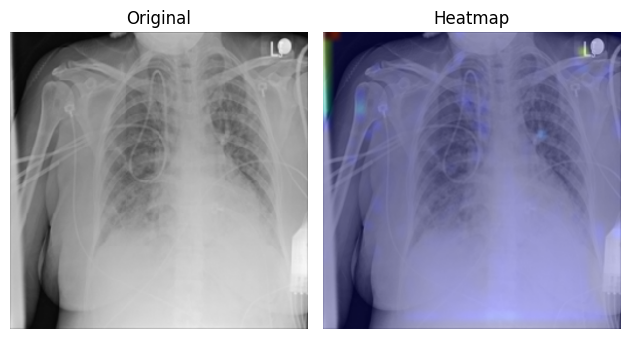

In [ ]:
generate_heatmap_from_image(model, r"/content/COVID-19_Radiography_Testset/Lung_Opacity/Lung_Opacity-106.png", last_conv_layer_name, classifier_layer_names)

1/1 [==============================] - 0s 34ms/step

Valori originali: [[3.6450547e-11 8.8254459e-11 2.6501637e-10 1.0000000e+00]]
Probabilità per classe: [['0,00', '0,00', '0,00', '1,00']] 



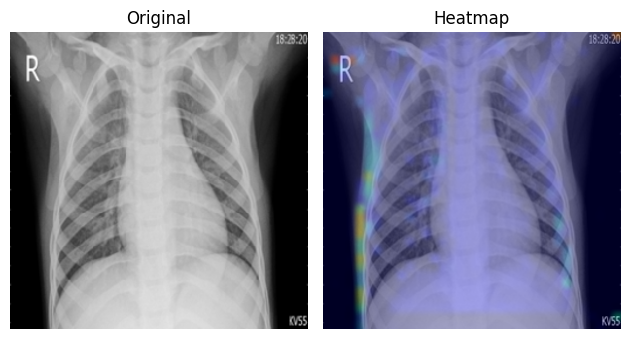

In [ ]:
generate_heatmap_from_image(model, r"/content/COVID-19_Radiography_Testset/Viral Pneumonia/Viral Pneumonia-2.png", last_conv_layer_name, classifier_layer_names)

Nelle classificazioni Covid e Viarl Pneumonia si ottengono delle heatmap più accese rispetto che per le altre due classi. Questo potrebbe spiegare perché i modelli tendono, in base a quanto appare nelle confusion matrix, a discriminare con minor precisione proprio tra queste due classi. Quanto osservato può essere dovuto all'effettiva somiglianza tra i casi.

## **CONCLUSIONI**

Nell'elaborato sono state presentate le prestazioni di tre modelli differenti. Il modello con le prestazioni migliori risulta essere il preaddestrato Vgg16 applicato in transfer learning (0,91 % accuracy) , seguito dal modello 1 addestrato da zero che offre prestazioni comunque soddisfacenti (0,87-0,88% di accuracy) nella classificazione. Il modello 2, nonostante la maggiore complessità e il conseguente aumento del tempo richiesto per l'addestramento, non sembra aver apportato miglioramenti ai risultati sul test set.
Si può concludere che è possibile ottenere buone performance nella classificazione applicata alle classi proposte, con maggior predilezione per quanto riguarda la classe di maggior interesse (Covid-19). Le classi meglio discriminate, considerando sia precision che recall, risultano essere Covid (classe 0) e Viral Pneumonia (Classe 3). Le altre due classi, pur registrando buoni risultati, sono le più difficili da discriminare, nonostante siano le meglio rappresentate numericamente nel dataset di partenza. Si può confermare che l'apprendimento autonomo è in grado di supportare ed eventualmente potenziare il processo decisionale umano.

La data augmentation ha dato parzialmente i risultati sperati. Le tecniche del flip hanno contributo a diminuire ulteriormente l'overfitting dei modelli, mentre l'aggiunta di rotazione e modifica della luminosità hanno peggiorato i risultati.

Per quanto riguarda la spiegabilità algoritmica, si è potuta osservare una parte delle dinamiche che ha portato il modello preso in esempio ad effettuare alcune specifiche classificazioni, risultando particolarmente utile per quanto riguarda la classe Covid-19.

## **LIMITI**


Il dataset di riferimento è una rappresentazione parziale della realtà di riferimento. Infatti, i dati sono suddivisi tra sole 4 classi e, dunque, non possono essere ritenute sufficienti a rappresentare l'eterogeneità della realtà di riferimento. Ad esempio, i modelli potrebbero non essere in grado di discriminare tra covid e una malattia che colpisce l'apparato respiratorio in maniera affine, in quanto questa non è presente nei dati sui quali i modelli sono stati addestrati.

Inoltre, la dimensione del dataset, sebbene non sia troppo ridotta e siano state anche applicate tecniche di data augmentation per la sua espansione, limita la robustezza dell'analisi per quanto riguarda la rappresentatività dei dati (meno esempi coperti rispetto ad un dataset più grande).

Le risorse hardware a disposizione rappresentano un limite all'analisi, in quanto o non sono sufficienti ad elaborare modelli di elevata complessità (nel caso del mio hardware personale) o sono disponibili solo per limitati periodi di tempo (limiti per usufruire delle GPU gratuitamente in Google Colab).